<div style="background: linear-gradient(90deg, #1d479b 0%, #3498db 100%);
    padding: 40px;
    border-radius: 10px;
    box-shadow: 0 4px 15px rgba(0,0,0,0.1);
    text-align: center;
    color: white;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    <h1 style="margin: 0; font-size: 2.8em; font-weight: 700; text-transform: uppercase; letter-spacing: 2px;">
        Machine learning Project: Seattle Energy
    </h1>
    <hr style="width: 100px; border: 2px solid #f1c40f; margin: 20px auto;">
    <p style="font-size: 1.2em; font-style: italic; opacity: 0.9; text-align: center;">
    Analyse et Prédiction de la Consommation Énergétique des Bâtiments Non-Résidentiels
    </p>
</div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import skew, kurtosis

warnings.filterwarnings('ignore')

# Configuration esthétique premium
sns.set_theme(style="whitegrid", palette="viridis", context="talk")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['font.family'] = 'sans-serif'

DATA_URL = "https://raw.githubusercontent.com/MouslyDiaw/handson-machine-learning/refs/heads/master/data/2016_Building_Energy_Benchmarking.csv"

print(" Environnement configuré et prêt pour l'analyse.")

 Environnement configuré et prêt pour l'analyse.


## 1. Chargement et nettoyage des données


Dans cette section, nous importons les librairies nécessaires et chargeons le jeu de données pour une première inspection

Nous filtrons les données pour nous concentrer sur les bâtiments **non-résidentiels** et nous supprimons les variables non pertinentes pour notre problématique de prédiction.
En effet, comme il s'agit de predire la consommation totale d'énergie des bâtiments non résidentiels, nous supprimons allons filtrer la variable TypeBuilding pour conserver que les bâtiments non résidentiels.

Pour le choix des variables, nous avons juger pertinente que de garder des variables qui apportent des informations pertinentes pour prédire la consommation d'énergie.

Enfin, pour eviter le data leakage, nous avons supprimé toutes les variables donnant des informations sur relatives à la consommation d'energie.

In [3]:
# ==============================================================================
# CHARGEMENT ET NETTOYAGE INITIAL DES DONNÉES
# ==============================================================================

# 1. Chargement du dataset
df_raw = pd.read_csv(DATA_URL)
print(f"Dataset chargé : {df_raw.shape[0]} lignes, {df_raw.shape[1]} colonnes.")

# 2. Filtrage métier : Focus sur les bâtiments non-résidentiels
# Nous excluons les types de bâtiments résidentiels conformément aux objectifs de l'étude
residential_types = ['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)']
df = df_raw[~df_raw['BuildingType'].isin(residential_types)].copy()
print(f"Filtrage non-résidentiel : {df.shape[0]} lignes restantes.")

# 3. Traitement des doublons sur l'identifiant unique OSEBuildingID
# On ne conserve que la première occurrence de chaque bâtiment
initial_rows = df.shape[0]
duplicate_count = df.duplicated(subset=['OSEBuildingID']).sum()

if duplicate_count > 0:
    df.drop_duplicates(subset=['OSEBuildingID'], keep='first', inplace=True)
    print(f"Suppression de {duplicate_count} doublons techniques.")
else:
    print("Aucun doublon détecté sur OSEBuildingID.")

# 4. Élimination des variables non pertinentes ou sources de fuite de données
# Nous supprimons les identifiants, les données géographiques redondantes,
# et surtout les variables liées à la consommation qui sont calculées à partir de la cible.
cols_to_drop = [
    'OSEBuildingID', 'DataYear', 'PropertyName', 'City', 'State',
    'TaxParcelIdentificationNumber', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)',
    'DefaultData', 'Comments', "NaturalGas(kBtu)", 'ComplianceStatus', 'Outlier',
    'TotalGHGEmissions', 'GHGEmissionsIntensity', "Address", 'SteamUse(kBtu)',
    'Electricity(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)'
]

# 5. Nettoyage de la variable cible (SiteEnergyUse)
# Suppression des valeurs nulles, négatives ou manquantes sur la cible pour la régression
df = df[df['SiteEnergyUse(kBtu)'] > 0].dropna(subset=['SiteEnergyUse(kBtu)'])

df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

print(f"Nettoyage terminé. Taille finale du dataset : {df.shape}")

Dataset chargé : 3376 lignes, 46 colonnes.
,Filtrage non-résidentiel : 1668 lignes restantes.
,Aucun doublon détecté sur OSEBuildingID.
,Nettoyage terminé. Taille finale du dataset : (1650, 23)


### Inspection de la structure
La méthode `info()` nous permet de vérifier rapidement les types de données et le nombre de valeurs non-nulles pour chaque variable.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
,Index: 1650 entries, 0 to 3375
,Data columns (total 23 columns):
, #   Column                           Non-Null Count  Dtype  
,---  ------                           --------------  -----  
, 0   BuildingType                     1650 non-null   object 
, 1   PrimaryPropertyType              1650 non-null   object 
, 2   ZipCode                          1634 non-null   float64
, 3   CouncilDistrictCode              1650 non-null   int64  
, 4   Neighborhood                     1650 non-null   object 
, 5   Latitude                         1650 non-null   float64
, 6   Longitude                        1650 non-null   float64
, 7   YearBuilt                        1650 non-null   int64  
, 8   NumberofBuildings                1650 non-null   float64
, 9   NumberofFloors                   1650 non-null   int64  
, 10  PropertyGFATotal                 1650 non-null   int64  
, 11  PropertyGFAParking               1650 non-null   int64  
, 12  Property

**Observation Statistique :**

Le jeu de données filtré contient 1650 bâtiments (lignes) et 23 variables (colonnes).
On distingue deux groupes principaux de variables: 15 variables numériques (int64 et float64), 8 variables catégorielles (object) :
Concernant les valeurs manquantes, la variable cible SiteEnergyUse(kBtu) est complète (1650 valeurs). En revanche, l'ENERGYSTARScore et bien d'autres variables contiennent des valeurs manquantes.

### 1.1 Aperçu des Données

In [5]:
# Affichage des premières lignes
print(" Aperçu des premières lignes du dataset:")
display(df.head())

print(f" État actuel de la base :")
print(f"- Nombre d'observations (lignes) : {df.shape[0]}")
print(f"- Nombre de variables (colonnes)  : {df.shape[1]}")

 Aperçu des premières lignes du dataset:


BuildingType PrimaryPropertyType  ZipCode  CouncilDistrictCode  \
0  NonResidential               Hotel  98101.0                    7   
1  NonResidential               Hotel  98101.0                    7   
2  NonResidential               Hotel  98101.0                    7   
3  NonResidential               Hotel  98101.0                    7   
4  NonResidential               Hotel  98121.0                    7   

  Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
0     DOWNTOWN  47.61220 -122.33799       1927                1.0   
1     DOWNTOWN  47.61317 -122.33393       1996                1.0   
2     DOWNTOWN  47.61393 -122.33810       1969                1.0   
3     DOWNTOWN  47.61412 -122.33664       1926                1.0   
4     DOWNTOWN  47.61375 -122.34047       1980                1.0   

   NumberofFloors  ...      ListOfAllPropertyUseTypes  LargestPropertyUseType  \
0              12  ...                          Hotel                   Hotel   
1              11  ...     Hotel, Parking, Restaurant                   Hotel   
2              41  ...                          Hotel                   Hotel   
3              10  ...                          Hotel                   Hotel   
4              18  ...  Hotel, Parking, Swimming Pool                   Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   756493.0                          NaN   
3                    61320.0                          NaN   
4                   123445.0                      Parking   

  SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseType  \
0                             NaN                          NaN   
1                         15064.0                   Restaurant   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                         68009.0                Swimming Pool   

  ThirdLargestPropertyUseTypeGFA  YearsENERGYSTARCertified ENERGYSTARScore  \
0                            NaN                       NaN            60.0   
1                         4622.0                       NaN            61.0   
2                            NaN                       NaN            43.0   
3                            NaN                       NaN            56.0   
4                            0.0                       NaN            75.0   

   SiteEnergyUse(kBtu)  
0            7226362.5  
1            8387933.0  
2           72587024.0  
3            6794584.0  
4           14172606.0  

[5 rows x 23 columns]

 État actuel de la base :
,- Nombre d'observations (lignes) : 1650
,- Nombre de variables (colonnes)  : 23


## 2. Analyse Exploratoire des Données (EDA)

Nous allons maintenant explorer les données pour comprendre les distributions et les relations entre les variables. Cela inclut des statistiques descriptives et des visualisations.



### 2.1 Statistiques Descriptives
Nous presentons quelques statistiques descriptives pour comprendre la distribution de nos variables clés.

In [6]:
stats_desc = df.describe().T
stats_desc['skewness'] = df.apply(lambda x: skew(x.dropna()) if x.dtype != 'object' else np.nan)
stats_desc['kurtosis'] = df.apply(lambda x: kurtosis(x.dropna()) if x.dtype != 'object' else np.nan)

display(stats_desc.style.background_gradient(cmap='YlGnBu'))

print(f"\nSkewness de la cible (SiteEnergyUse) : {df['SiteEnergyUse(kBtu)'].skew():.2f}")


,Skewness de la cible (SiteEnergyUse) : 17.97


### ANALYSE DES STATISTIQUES DESCRIPTIVES DU JEU DE DONNÉES

Les statistiques révèlent une grande hétérogénéité des structures et des distributions présentant une forte asymétrie positive.

#### 1. Structure Physique et Âge du Parc Immobilier
* **Âge des bâtiments :**  La médiane (1965) indique que plus de 50% du parc a été construit avant ou dans les années 60.
* **Élévation :** Les bâtiments possèdent en moyenne 4 étages, bien que l'échantillon comprenne des structures de grande hauteur s'élevant jusqu'à 99 étages.
* **Complexité :** Bien que la plupart des entrées concernent des bâtiments uniques, la présence d'un maximum de 111 bâtiments (NumberofBuildings) indique l'existence de complexes de type campus qui peuvent présenter des défis dans la modélisation en tant qu'outliers.

#### 2. Analyse des Surfaces (GFA - Gross Floor Area)
Les variables de surface présentent une asymétrie (skewness) très élevée, notamment pour PropertyGFATotal (19.32).
* **Distribution :** La moyenne (~118 562 sq.ft) est largement supérieure à la médiane (~49 059 sq.ft), confirmant que quelques très grands bâtiments influencent fortement la moyenne.
* **Usage :** La surface est majoritairement dédiée au bâti (PropertyGFABuilding(s)), tandis que la surface de parking est nulle pour plus de 50% des observations.

#### 3. Indicateurs de Performance et Consommation (Cible)
* **ENERGY STAR Score :** La moyenne se situe à 65.4. On note que 25% des bâtiments ont un score inférieur à 48.
* **SiteEnergyUse (kBtu) :** La variable cible présente une dispersion extrême (de 16 808 à 873 923 712 kBtu) et une skewness de 17.95. Ces caractéristiques valident l'utilisation de la transformation logarithmique pour stabiliser la variance lors de l'entraînement.

#### 4. Synthèse Technique pour la Modélisation
* **Normalisation :** L'asymétrie extrême des surfaces et des consommations confirme la nécessité de la transformation Log-Log validée par le test de Kolmogorov-Smirnov(plus bas).
* **Algorithmes :** L'hétérogénéité du parc justifie l'approche par Stacking Regressor, permettant de combiner des modèles robustes aux outliers (comme les forêts d'arbres décisionnels) avec un méta-apprenant capable de généraliser sur l'ensemble du spectre de consommation.

 ### 2.2 Analyse des types de bâtiments

Nous allons regarder la répartition des différents types de bâtiments présents dans le jeu de données.

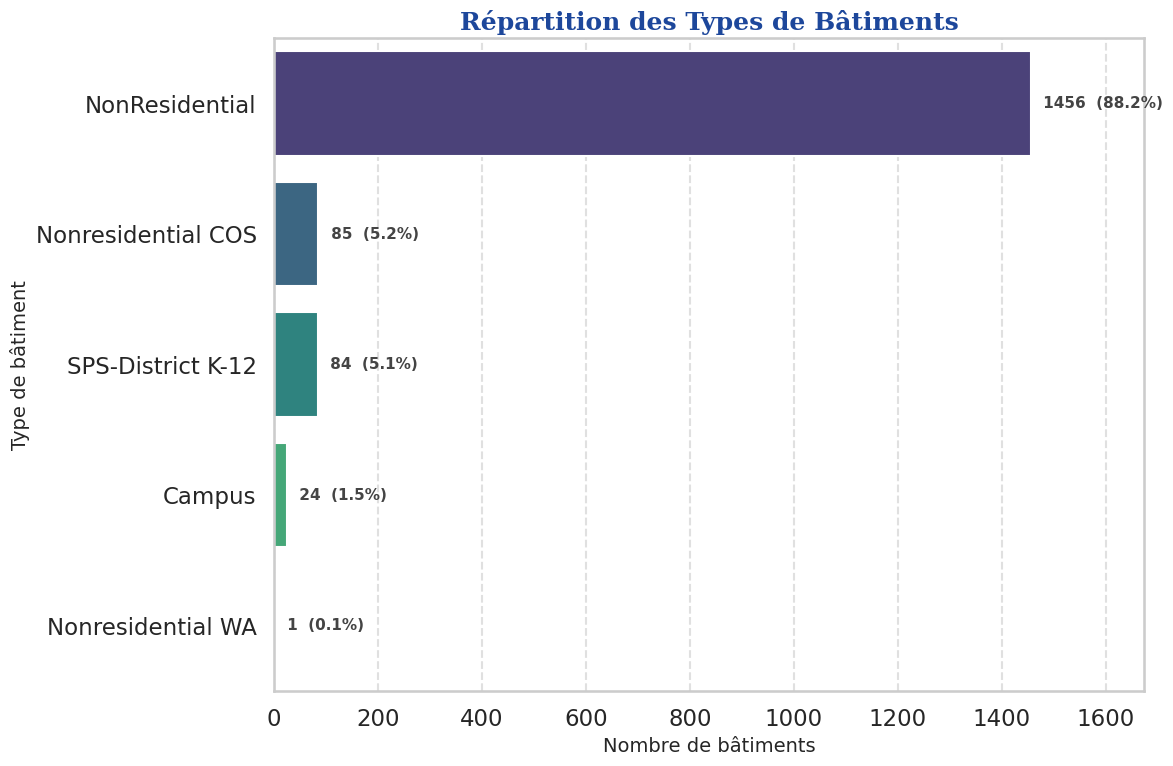

In [7]:
# 1. Préparation des données
# On compte les occurrences et on les trie du plus grand au plus petit
building_counts = df['BuildingType'].value_counts().sort_values(ascending=False)

# 2. Configuration du graphique
font_title = {'family': 'serif', 'color': '#1d479b', 'weight': 'bold', 'size': 18}
plt.figure(figsize=(12, 8))

# 3. Création du Bar Chart Horizontal
# Utilisation de la palette 'viridis' (très différente du pastel précédent)
sns.barplot(
    x=building_counts.values,
    y=building_counts.index,
    palette="viridis",
    hue=building_counts.index, # Pour éviter les warnings futurs de Seaborn
    legend=False
)

# 4. Ajout des annotations (Valeur + Pourcentage)
total = building_counts.sum()
for i, v in enumerate(building_counts.values):
    percent = f"{(v/total)*100:.1f}%"
    # On place le texte un peu à droite de la barre
    plt.text(v + (max(building_counts.values)*0.01), i,
             f" {v}  ({percent})",
             va='center', fontsize=11, fontweight='bold', color='#444444')

# 5. Titres et Labels
plt.title("Répartition des Types de Bâtiments", fontdict=font_title)
plt.xlabel("Nombre de bâtiments")
plt.ylabel("Type de bâtiment")
plt.grid(axis='x', linestyle='--', alpha=0.6) # Grille verticale légère
plt.xlim(0, max(building_counts.values) * 1.15) # On laisse de la place à droite pour le texte

plt.tight_layout()
plt.show()

**Interprétation** :

Nous constatons que la majeur partie des bâtiments sont de type **"NonResidential"**. Nous pouvons visualiser les diverses catégories représentées dans ce type de bâtiments : On a 88,2% des bâtiments typés **"NonResidential"**, 5,2% des bâtiments types  **"Nonresidential COS"**, 5,1% des bâtiments types **"SPS-Districk K-12"**, 1,5% des bâtiments types **"Campus"** et 0,1% des bâtiments typés **"Nonresidential WA"**.

## 2.3 Analyses sur les autres caractéristiques

### 2.3.1 **Analyse de la répartition des types de bâtiments**
Nous allons d'abord analyser la répartition des types de propriétés spécifiquement pour les bâtiments classés comme "Non-Résidentiels"

In [8]:
df.loc[(df['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office    287
Other                          183
Warehouse                      180
Large Office                   168
Mixed Use Property             101
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             51
Supermarket / Grocery Store     40
K-12 School                     39
Medical Office                  38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             2
Name: count, dtype: int64

**Interpretation:**

Cette analyse montre une grande diversité d'usages parmi les bâtiments non-résidentiels de Seattle. Les bureaux de petite et moyenne taille (Small- and Mid-Sized Office, 287) représentent la catégorie la plus fréquente. Associé aux grands bureaux (Large Office, 168), les espaces de travail administratif constituent la majorité du parc étudié (plus de 450 bâtiments). Nous observons aussi que les entrepôts (Warehouse, 180) et les centres de distribution représentent une partie significative du parc (180 bâtiments). On observe aussi une longue traîne de bâtiments variés (Commerces, Hôtels, Écoles, Lieux de culte). Avec 183 bâtiments, la catégorie "Other" est la deuxième plus importante. Cela suggère qu'il existe de nombreux types de bâtiments spécifiques qui n'entrent pas dans les classifications standards de Seattle.

### 2.3.2 **Analyse comparative de la consommation d'énergie**
Nous allons maintenant évaluer les consommations d'énergie entre les différents types de bâtiments.

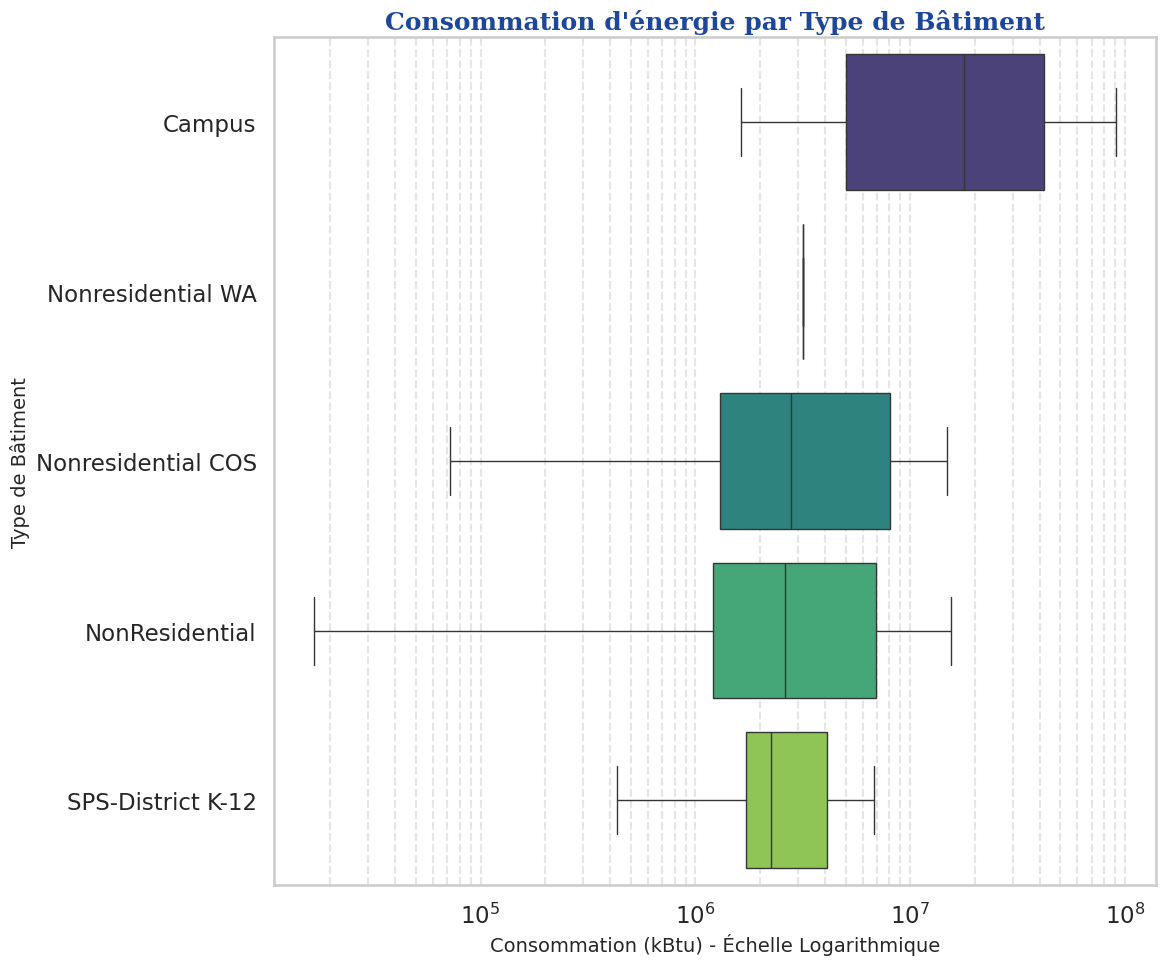

In [9]:
# 1. Préparation : On trie les types de bâtiments par consommation médiane
# Cela permet d'avoir un graphique ordonné du plus gourmand au plus sobre
order_types = df.groupby('BuildingType')['SiteEnergyUse(kBtu)'].median().sort_values(ascending=False).index

# 2. Configuration
font_title = {'family': 'serif', 'color': '#1d479b', 'weight': 'bold', 'size': 18}
plt.figure(figsize=(12, 10)) # Assez grand en hauteur pour lire tous les types

# 3. Création du Boxplot
sns.boxplot(
    data=df,
    x='SiteEnergyUse(kBtu)',
    y='BuildingType',
    order=order_types,
    palette='viridis',
    showfliers=False
)

# 4. Ajustements
plt.xscale('log')
plt.title("Consommation d'énergie par Type de Bâtiment", fontdict=font_title)
plt.xlabel("Consommation (kBtu) - Échelle Logarithmique")
plt.ylabel("Type de Bâtiment")
plt.grid(True, which="both", axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Interpretation:**

On observe que certains types de bâtiments comme les **Campus**, **Nonresidential**, **Nonresidential COS** situent nettement plus à droite, confirmant qu'ils sont structurellement plus gourmands en énergie(surtout pour les campus). On observe egalement une forte disparité au sein d'une même catégorie, suggérant que d'autres facteurs (âge, équipements) influenceraient aussi la consommation.

### 2.3.3 **Analyse de l'année de construction des bâtiments**
Nous analysons la distribution des bâtiments par année de construction.


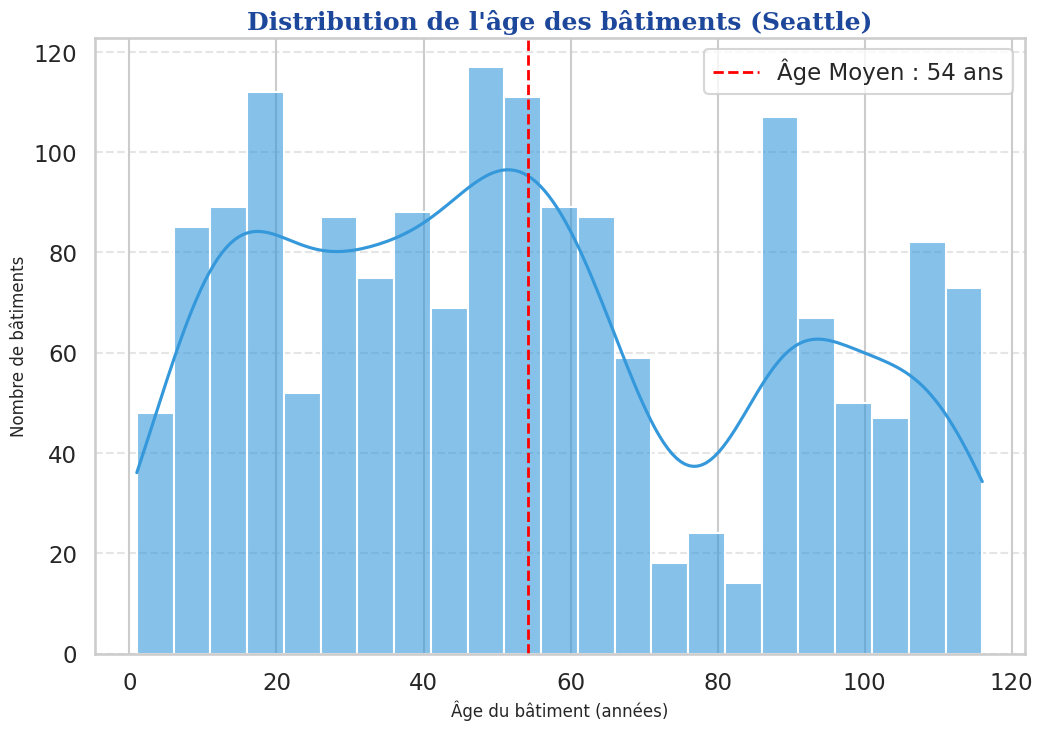

In [10]:
# On définit la variable âge des batiments
df['BuildingAge'] = 2016 - df['YearBuilt']

# 2. Configuration
font_title = {'family': 'serif', 'color': '#1d479b', 'weight': 'bold', 'size': 18}
plt.figure(figsize=(12, 8))

# 3. Création de l'Histogramme avec Courbe de Densité (KDE)
# binwidth=5 permet de regrouper par tranches de 5 ans
ax = sns.histplot(data=df, x='BuildingAge', kde=True, binwidth=5, color='#3498db', alpha=0.6)

# 4. Ajout de la ligne de moyenne (Indicateur clé)
mean_age = df['BuildingAge'].mean()
plt.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Âge Moyen : {mean_age:.0f} ans')

# 5. Esthétique
ax.set_xlabel("Âge du bâtiment (années)", fontsize=12)
ax.set_ylabel("Nombre de bâtiments", fontsize=12)
plt.title(f"Distribution de l'âge des bâtiments (Seattle)", fontdict=font_title)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

**Interpretation:**

La distribution de l’âge des bâtiments met en évidence un parc immobilier ancien et hétérogène, avec un âge moyen d’environ **54 ans**. La distribution de l’âge des bâtiments apparaît hétérogène et multimodale, ce qui suggère l’existence de plusieurs vagues de construction à différentes périodes.
On observe une concentration des bâtiments entre 20 et 40 ans, autour de 50–60 ans, ainsi qu’un groupe plus ancien dépassant 80 ans.
On observe aussi la présence de bâtiments très anciens (jusqu’à plus de 100 ans) traduit une longue histoire du parc immobilier.
L'âge est un facteur clé car les bâtiments plus anciens n'ont pas bénéficié des mêmes normes d'isolation thermique que les constructions modernes, ce qui pourrait expliquer des consommations plus élevées.

### 2.3.4 **Analyse de la consommation moyenne d'energie à travers les époques**

Nous allons maintenant étudier la consommation moyenne d'energie à travers les différentes époques de construction des bâtiments.

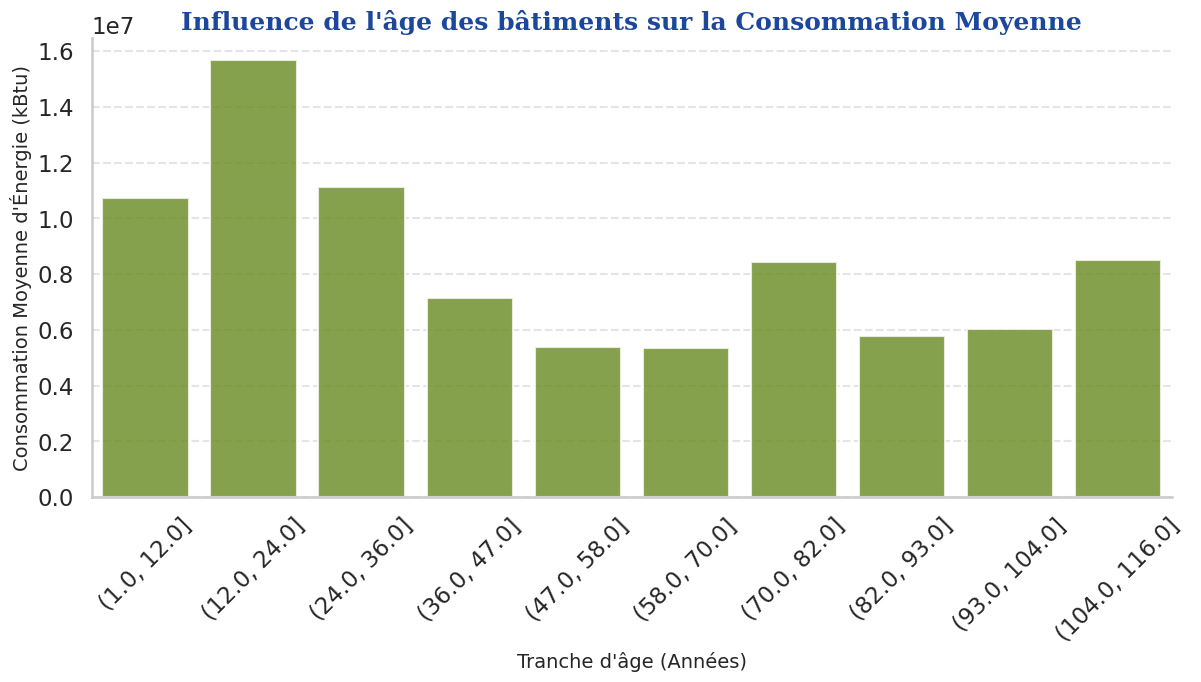

In [11]:
# 1. Création des intervalles (Bins)
# On découpe l'âge en 10 catégories automatiques pour voir les tendances par décennie
# (On crée une colonne temporaire pour que le graphique soit propre)
df['Age_Category'] = pd.cut(df['BuildingAge'], bins=10, precision=0)

# 2. Configuration du style
font_title = {'family': 'serif', 'color': '#1d479b', 'weight': 'bold', 'size': 18}

# 3. Création du Catplot (Barres)
g = sns.catplot(
    data=df,
    kind="bar",
    x="Age_Category",
    y="SiteEnergyUse(kBtu)",
    errorbar=None,
    color="#6D9C0E",
    alpha=0.8,
    height=6,
    aspect=2
)

# 4. Esthétique et Titres
plt.title("Influence de l'âge des bâtiments sur la Consommation Moyenne", fontdict=font_title)
plt.xlabel("Tranche d'âge (Années)")
plt.ylabel("Consommation Moyenne d'Énergie (kBtu)")

# Rotation des étiquettes de l'axe X pour qu'elles ne se chevauchent pas
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# Nettoyage (On retire la colonne temporaire)
df.drop(columns=['Age_Category'], inplace=True)

**Interpretation:**

L’analyse par tranche d’âge met en évidence une relation non linéaire entre l’ancienneté des bâtiments et leur consommation énergétique moyenne. Les bâtiments récents (1–24 ans) présentent les consommations moyennes les plus élevées, avec un pic notable dans la tranche 12–24 ans.
La consommation diminue progressivement pour les bâtiments d’âge intermédiaire (36–70 ans), atteignant des niveaux plus faibles.

Une remontée de la consommation est observée pour les bâtiments plus anciens (70 ans et plus), notamment au-delà de 80 ans. Donc les bâtiments récents et très anciens présentent des niveaux de consommation plus élevés, tandis que les bâtiments d’âge intermédiaire sont globalement plus sobres.

### 2.3.5 **Analyse géographique interactive**

Nous passons d'une analyse purement statistique à une analyse géographique interactive afin de visualiser les bâtiments par rapport à la localisation géographique.

In [12]:
import folium
from folium.plugins import MarkerCluster

# 1. Définition du centre
seattle_lat = df['Latitude'].mean()
seattle_lon = df['Longitude'].mean()

# 2. Création de la carte
seattle_map = folium.Map(location=[seattle_lat, seattle_lon], zoom_start=11, tiles='cartodbpositron')

# 3. Cluster
marker_cluster = MarkerCluster().add_to(seattle_map)

# 4. Ajout des Marqueurs avec Infos Détaillées
# On ajoute la Surface et la Conso dans la boucle zip()
for lat, lng, b_type, surf, conso in zip(df['Latitude'], df['Longitude'], df['BuildingType'], df['PropertyGFATotal'], df['SiteEnergyUse(kBtu)']):

    # Création d'un contenu HTML pour le popup
    popup_content = f"""
    <div style="width: 150px;">
        <b>Type :</b> {b_type}<br>
        <b>Surface :</b> {surf:,.0f} sqft<br>
        <b>Conso :</b> {conso:,.0f} kBtu
    </div>
    """

    folium.Marker(
        location=[lat, lng],
        popup=folium.Popup(popup_content, max_width=200),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# 5. Affichage
seattle_map

**Interpretation:**

La carte confirme une forte densité de bâtiments non-résidentiels dans le centre-ville.

L'utilisation des clusters permet de naviguer efficacement dans le parc immobilier. Les popups fournissent un accès rapide aux caractéristiques clés (Surface et Consommation) sans quitter l'interface géographique. La proximité géographique entre certains bâtiments pourra être explorée ultérieurement pour voir si l'appartenance à un même quartier (Neighborhood) influence les habitudes de consommation.

### 2.2.6 **Analyse de la densité spatiale de la consommation d'énergie**
Nous visualisons la densité de la consommation d'énergie pour savoir où se concentre la charge energetique de la ville.

In [13]:
import folium
from folium.plugins import HeatMap

# 1. Préparation des données pour la Heatmap
# On a besoin d'une liste de points : [Latitude, Longitude, Poids]
# Le "Poids" sera la consommation d'énergie. Plus c'est haut, plus c'est rouge.
heat_data = df[['Latitude', 'Longitude', 'SiteEnergyUse(kBtu)']].values.tolist()

# 2. Création de la carte de base
seattle_map_heat = folium.Map(location=[seattle_lat, seattle_lon], zoom_start=11, tiles='cartodbpositron')

# 3. Ajout de la couche de chaleur
HeatMap(
    heat_data,
    radius=15,      # Rayon de chaque point
    blur=20,
    max_zoom=1,
).add_to(seattle_map_heat)

# 4. Titre (Ajout d'un titre flottant en HTML/CSS sur la carte)
title_html = '''
     <h3 align="center" style="font-size:16px"><b>Zones de forte consommation énergétique</b></h3>
             '''
seattle_map_heat.get_root().html.add_child(folium.Element(title_html))

# 5. Affichage
seattle_map_heat

**Interprétation:**

On identifie clairement des pôles de forte consommation, principalement situés au centre de la ville (ce qui justifie plus tard la création d'une variable qui mesure la distance par rapport au centre). Ces zones représentent les plus grands défis en termes de réduction d'empreinte carbone pour la ville.

Cette visualisation justifit l'utilisation de variables de localisation au centre ville dans notre modèle de prédiction, car la consommation semble fortement liée à l'emplacement géographique et à la densité urbaine.


## 3. Analyse des Valeurs Manquantes

Nous analysons les valeurs manquantes.

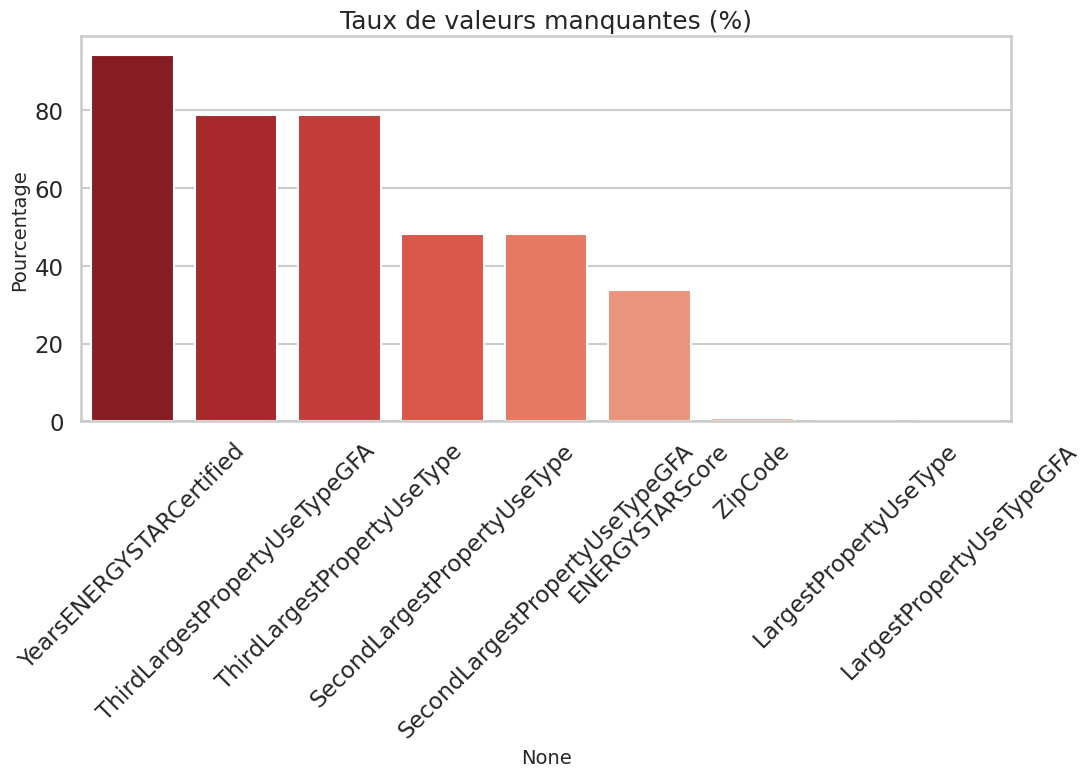

Taux de remplissage de l'ENERGYSTARScore : 66.24%


In [14]:
plt.figure(figsize=(12, 5))
missing_data = df.isnull().mean() * 100
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if not missing_data.empty:
    sns.barplot(x=missing_data.index, y=missing_data.values, palette='Reds_r')
    plt.xticks(rotation=45)
    plt.title("Taux de valeurs manquantes (%)")
    plt.ylabel("Pourcentage")
    plt.show()
else:
    print("Aucune valeur manquante détectée dans les colonnes restantes.")

print(f"Taux de remplissage de l'ENERGYSTARScore : {100 - (df['ENERGYSTARScore'].isnull().mean()*100):.2f}%")

### ANALYSE DES VALEURS MANQUANTES ET STRATÉGIE DE NETTOYAGE

L'analyse du graphique des valeurs manquantes est une étape cruciale pour valider la fiabilité des variables prédictives avant la modélisation.

#### 1. Identification des Variables Critiques
* **ENERGYSTARScore :** Cette variable présente un taux de manquants d'environ 33% (taux de remplissage de 66.24%).
* **Composantes de Surface secondaires :** Les variables liées aux deuxième et troisième usages les plus importants (`SecondLargestPropertyUseType`, `ThirdLargestPropertyUseType` et leurs surfaces respectives) affichent des taux de manquants élevés, allant de 50% à près de 80%.

#### 2. Interprétation Métier des Manquants
* **Absence d'Usage Multiple :** Les taux élevés pour les deuxième et troisième usages ne sont pas forcement des erreurs de collecte, mais pourraient indiquer que la majorité des bâtiments de Seattle ont un usage unique ou principal.
* **Certification ENERGY STAR :** La variable `YearsENERGYSTARCertified` est presque totalement vide (plus de 90%). Cela confirme que très peu de bâtiments possèdent cette certification historique, rendant la colonne inexploitable pour une prédiction statistique robuste.

#### 3. Impact sur le Feature Engineering
* **Filtrage :** Les colonnes dépassant 70-80% de valeurs manquantes (comme les certifications annuelles) ont été écartées pour éviter d'introduire du bruit ou des biais d'imputation.

* **Localisation :** Le `ZipCode` présente un taux de manquants négligeable, ce qui assure la fiabilité des analyses géographiques et du clustering basé sur la localisation.



## 4. Analyse de l'ENERGYSTARScore

### 4.1 **Analyse de la distribution et de la pertinence de la variable ENERGYSTARScore**

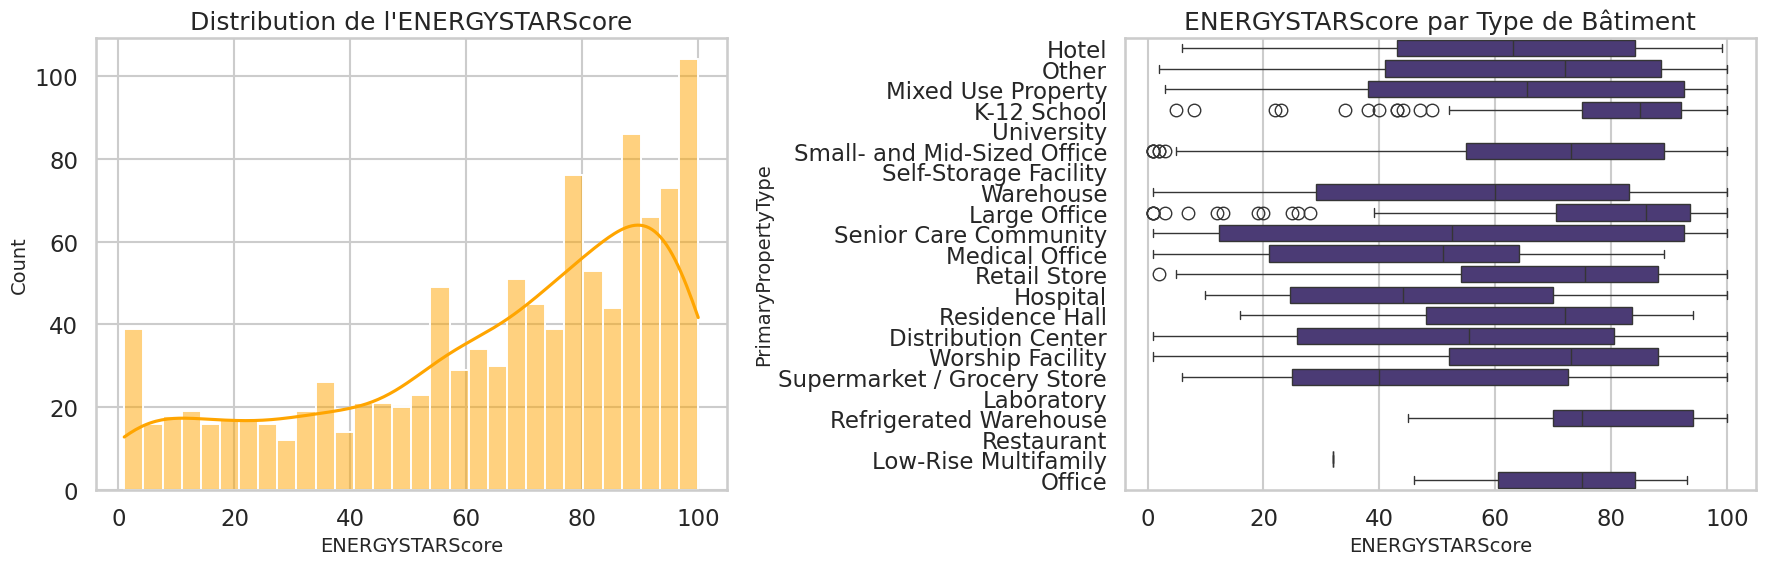

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(df['ENERGYSTARScore'].dropna(), bins=30, kde=True, ax=ax1, color='orange')
ax1.set_title("Distribution de l'ENERGYSTARScore")

sns.boxplot(data=df, x='ENERGYSTARScore', y='PrimaryPropertyType', ax=ax2)
ax2.set_title("ENERGYSTARScore par Type de Bâtiment")

plt.tight_layout()
plt.show()

**Interprétation** :

L'histogramme montre que la distribution des scores est assez étalée vers la gauche, ce qui suggère une grande diversité d'efficacité énergétique au sein de Seattle. Le pic principal se situe entre 90 et 100 et indique qu'un grand nombre de bâtiments de l'échantillon sont très performants d'un point de vue énergétique.
Le boxplot révèle des disparités notables entre les types de propriétés. Les variables **Refrigerated Warehouse**, **K-12 School** et **Large Office** présentent les médianes les plus élevées (souvent au-dessus de 75-80). Ils semblent être les types de propriétés les mieux gérés énergétiquement.
La variable **Large Office** ont une boîte très resserrée vers le haut, indiquant une performance élevée et homogène.

Les types **Hospital**, **Medical Office**, et **Senior Care Community** montrent une très grande dispersion. Cela signifie que dans ces catégories, on trouve aussi bien des bâtiments excellents que de très mauvais élèves

### 4.2 **Analyse des relations entre les variables**

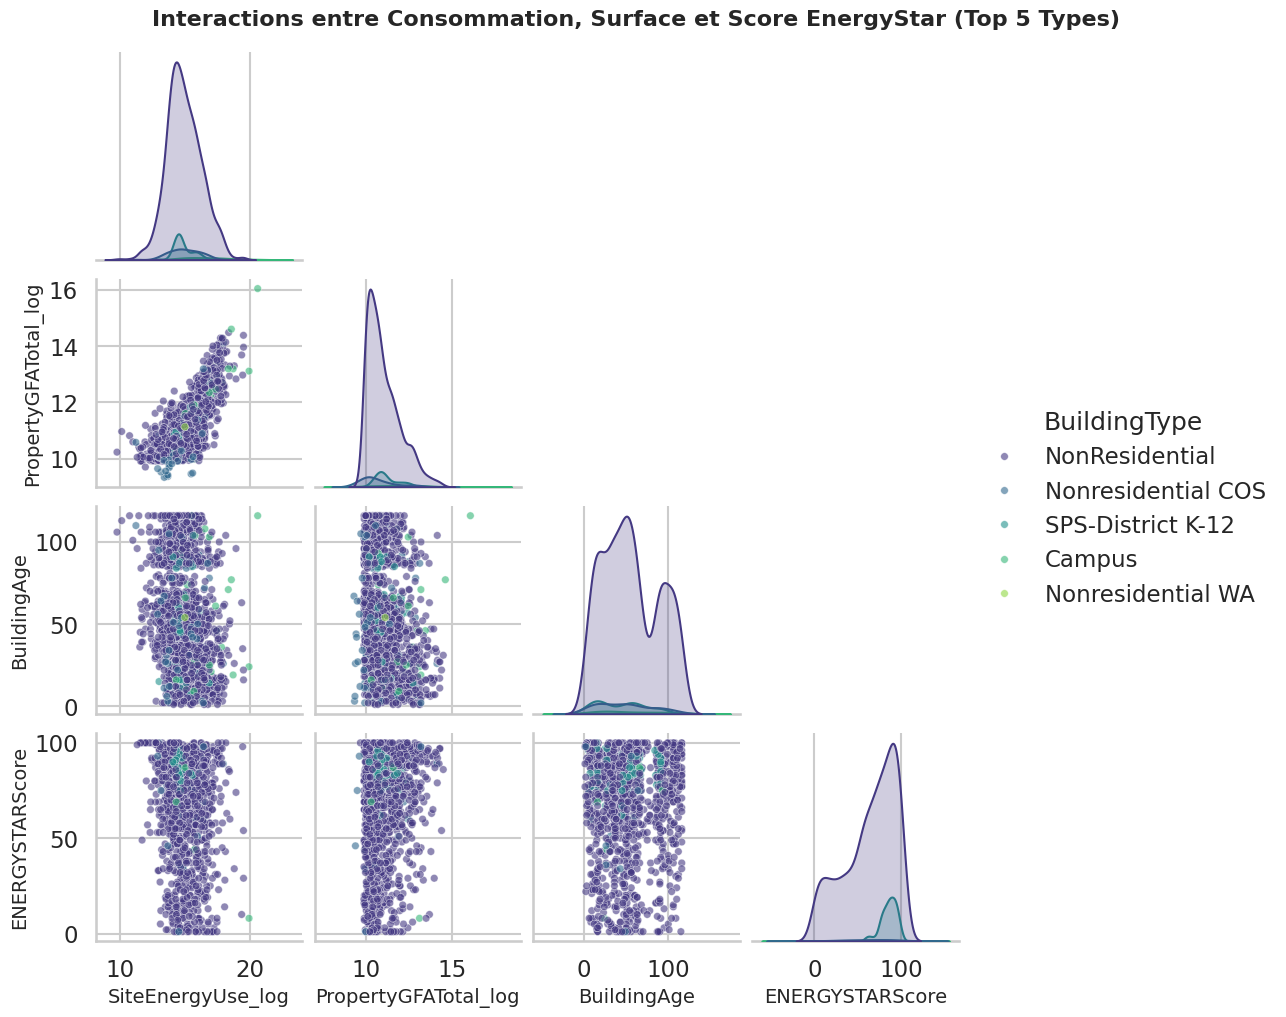

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

df['SiteEnergyUse_log'] = np.log(df['SiteEnergyUse(kBtu)'])
df['PropertyGFATotal_log'] = np.log(df['PropertyGFATotal'])

# 2. Sélection des variables clés pour le Pairplot
# On regarde : La Cible, La Surface, L'Âge et Le Score
vars_to_plot = ['SiteEnergyUse_log', 'PropertyGFATotal_log', 'BuildingAge', 'ENERGYSTARScore']

# 3. Création du Pairplot
# hue='BuildingType' permet de voir si l'impact du score dépend du type de bâtiment
sns.pairplot(
    data=df,
    vars=vars_to_plot,
    hue='BuildingType',
    palette='viridis',     # Couleurs distinctes
    corner=True,
    plot_kws={'alpha': 0.6, 's': 30},
    diag_kind='kde'        # Densité sur la diagonale
)

plt.suptitle("Interactions entre Consommation, Surface et Score EnergyStar (Top 5 Types)", y=1.02, fontsize=16, fontweight='bold')
plt.show()

**Interpretation du Pairplot :**

Le croisement entre PropertyGFATotal_log et SiteEnergyUse_log (deuxième ligne, première colonne) montre une nette. La forme allongée et linéaire du nuage de points confirme que la surface est un prédicteur notable de la consommation d'énergie.
On remarque que les bâtiments de type Campus (en vert clair) se situent dans la partie supérieure droite, étant à la fois les plus vastes et les plus énergivores.

Rôle de l'ENERGYSTARScore :
La relation entre le score et la consommation (SiteEnergyUse_log) est négative, donc plus le score est élevé (vers la droite sur l'axe X), plus la consommation a tendance à baisser.

Analyse de l'Ancienneté (BuildingAge) :
La distribution de l'âge (diagonale) montre deux pics distincts : un parc immobilier "historique" (80-100 ans) et un parc plus "moderne" (30-50 ans).
L'âge ne semble pas par contre avoir une corrélation linéaire forte avec la consommation brute(un vieux bâtiment bien rénové pourrait consommer moins qu'un bâtiment plus récent mais moins bien conçu.)

Distributions Marginales (La diagonale) :
Les courbes de densité confirment que les transformations logarithmiques ont été efficaces : SiteEnergyUse_log et PropertyGFATotal_log présentent des formes de "cloches" symétriques, idéales pour les modèles de régression.
Le type NonResidential (en violet) domine largement l'échantillon, mais les autres types (SPS-District, Campus) sont aussi bien représentés en termes de taille et de consommation.



### 4.3 **Analyse de la corrélation : Consommation vs EnergyStarScore**


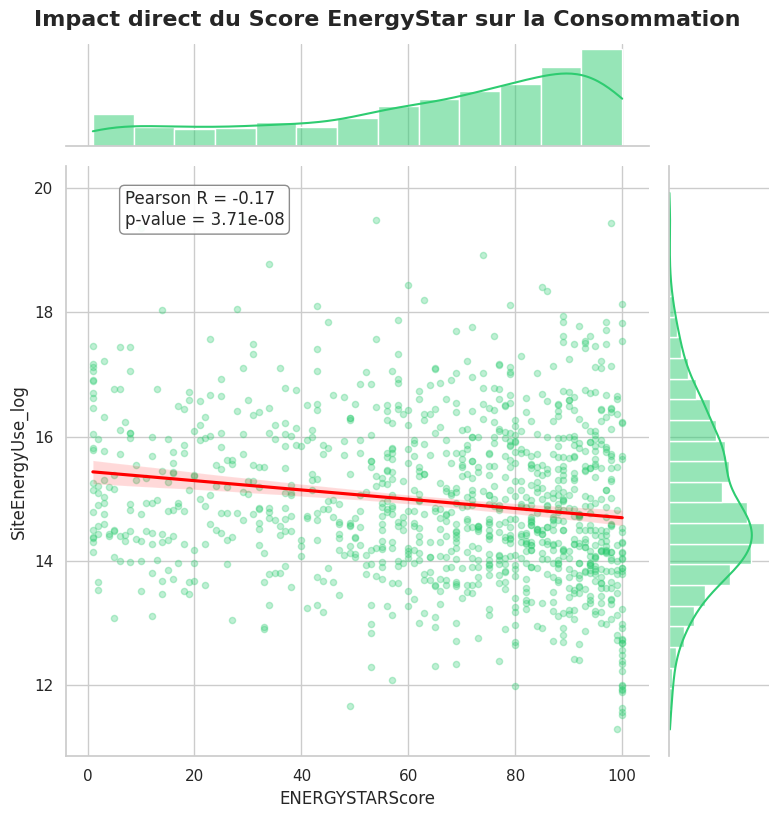

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Transformation log de la cible et de la surface
df['SiteEnergyUse_log'] = np.log(df['SiteEnergyUse(kBtu)'])
df['PropertyGFATotal_log'] = np.log(df['PropertyGFATotal'])

# 1. NETTOYAGE PRÉALABLE (Correction du bug)
# On garde uniquement les lignes où les DEUX variables sont présentes
df_clean = df.dropna(subset=['ENERGYSTARScore', 'SiteEnergyUse_log'])

# Configuration esthétique
sns.set_theme(style="whitegrid")

# 2. Création du Jointplot
g = sns.jointplot(
    data=df_clean,
    x="ENERGYSTARScore",
    y="SiteEnergyUse_log",
    kind="reg",
    color="#2ecc71",
    height=8,
    scatter_kws={'alpha': 0.3, 's': 20},
    line_kws={'color': 'red'}
)

# 3. Calcul des stats (sur les données alignées)
r, p = stats.pearsonr(df_clean['ENERGYSTARScore'], df_clean['SiteEnergyUse_log'])

# 4. Annotation
g.ax_joint.annotate(f'Pearson R = {r:.2f}\np-value = {p:.2e}',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.9),
                    fontsize=12)

g.fig.suptitle("Impact direct du Score EnergyStar sur la Consommation", y=1.02, fontsize=16, fontweight='bold')
plt.show()

**Interpretation:**

Le premier graphique montre une distribution étalée vers la gauche. La majorité des bâtiments se concentre entre les scores 60 et 100. Le pic le plus important se situe proche de 100, ce qui indique un parc globalement performant. On observe néanmoins un petit pic secondaire proche de 0. Ces bâtiments représentent des cibles prioritaires pour des audits énergétiques, car ils sont très en retard sur les normes d'efficacité.

Le deuxième graphique de corrélation  montre une droite de régression rouge descendante, ce qui confirme que plus le score ENERGY STAR est élevé, plus la consommation d'énergie (SiteEnergyUse_log) diminue. La corrélation est négative mais reste "faible" en valeur absolue. Cela suggère que si le score est un bon indicateur, il n'explique pas à lui seul toute la consommation ; d'autres facteurs (taille du bâtiment, année de construction, climat) jouent également un rôle important.

Significativité Statistique P-value ($3.71 \times 10^{-8}$) : Cette valeur est extrêmement proche de zéro (bien inférieure au seuil classique de $0.05$). Donc la relation entre le score et la consommation est statistiquement significative: améliorer le score ENERGY STAR d'un bâtiment garantit mathématiquement une baisse de sa consommation moyenne.

### 4.4 **Zoom sur les relations entre l'EnergyStarScore et les autres caractéristiques physiques des bâtiments**

Contrairement à une matrice globale, ce graphique permet de voir d'un coup d'œil ce qui influence la "note" d'un bâtiment.

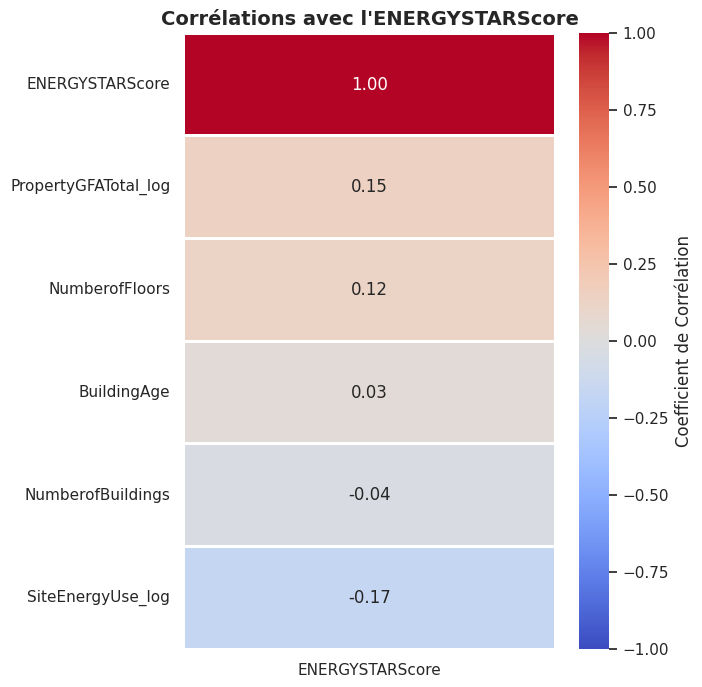

In [18]:
# 1. Sélection des variables numériques pertinentes
cols_corr = ['SiteEnergyUse_log', 'PropertyGFATotal_log', 'BuildingAge',
             'NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore']

# 2. Calcul de la matrice
corr_matrix = df[cols_corr].corr()

# 3. Focus sur la colonne "ENERGYSTARScore" uniquement
# On trie pour voir les corrélations les plus fortes en premier
score_corr = corr_matrix[['ENERGYSTARScore']].sort_values(by='ENERGYSTARScore', ascending=False)

# 4. Affichage Heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(
    score_corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    fmt=".2f",
    linewidths=1,
    linecolor='white',
    cbar_kws={'label': 'Coefficient de Corrélation'}
)
plt.title("Corrélations avec l'ENERGYSTARScore", fontsize=14, fontweight='bold')
plt.show()

**Interpretation:**

Le graphique présente les coefficients de corrélation de Pearson calculés entre la variable **ENERGYSTARScore** et des caractéristiques descriptives des bâtiments comme la surface totale (logarithme), le nombre d'étages, l'âge du bâtiment, le nombre de bâtiments sur le site, et la consommation énergétique totale du site (logarithme).

La surface totale du bien (PropertyGFA_total_log) et le nombre d'étages montrent une faible corrélation positive (respectivement +0,15 et +0,12), suggérant un léger avantage pour les bâtiments de plus grande taille et/ou plus hauts, potentiellement lié à des économies d'échelle dans les systèmes techniques ou à une plus grande proportion de bâtiments tertiaires modernes dans ces catégories.
L'âge du bâtiment (BuildingAge) et le nombre de bâtiments sur le site (NumberOfBuildings) présentent des corrélations quasi nulles (+0,03 et -0,04), indiquant que ces facteurs n'ont pratiquement aucun lien linéaire avec la performance énergétique telle que mesurée par le ENERGYSTARScore.
La variable la plus significative est la consommation énergétique totale du site (SiteEnergyUse_log) avec une corrélation négative de -0,17 : une consommation énergétique plus élevée est associée à un score légèrement moins bon, ce qui reste cohérent avec la logique de ENERGYSTARScore qui valorise l'efficacité énergétique.

Le variable ENERGYSTARScore apparaît relativement indépendant des caractéristiques architecturales et structurelles classiques des bâtiments.

## 5. Analyse de la Variable Cible & Transformation

### 5.1 **Vérification mathématique de la forme de nos données à l'aide du test de Kolmogorov-Smirnov (K-S).**

Nous procédons à une vérification mathématique de la forme de nos données à l'aide du test de Kolmogorov-Smirnov (K-S). Ce test permettra de justifier la transformation logarithmique

In [19]:
from scipy import stats

# Variables brutes à tester
variables_raw = ['SiteEnergyUse(kBtu)', 'PropertyGFATotal']

print(">>> TEST DE NORMALITÉ (KOLMOGOROV-SMIRNOV) - DONNÉES BRUTES <<<\n")

for var in variables_raw:
    # 1. Nettoyage des NaN
    data = df[var].dropna()

    # 2. Standardisation (Indispensable pour comparer à 'norm')
    # Z = (X - Mean) / Std
    data_std = (data - data.mean()) / data.std()

    # 3. Test K-S
    test_result = stats.kstest(data_std, 'norm')

    # 4. Affichage
    print(f"Variable : {var}")
    print(f"  Statistic : {test_result.statistic:.4f}")
    print(f"  P-value   : {test_result.pvalue:.4e}")

    if test_result.pvalue < 0.05:
        print("  => Conclusion : Distribution NON NORMALE (Rejet H0) ")
    else:
        print("  => Conclusion : Distribution NORMALE (H0 acceptée) ")
    print("-" * 60)

>>> TEST DE NORMALITÉ (KOLMOGOROV-SMIRNOV) - DONNÉES BRUTES <<<
,
,Variable : SiteEnergyUse(kBtu)
,  Statistic : 0.3898
,  P-value   : 2.8753e-226
,  => Conclusion : Distribution NON NORMALE (Rejet H0) 
,------------------------------------------------------------
,Variable : PropertyGFATotal
,  Statistic : 0.3616
,  P-value   : 8.8039e-194
,  => Conclusion : Distribution NON NORMALE (Rejet H0) 
,------------------------------------------------------------


### 5.2 **Visualisation de la distribution avant et après la transformation logarithmique de la variable "SiteEnergyUse(kBtu)".**



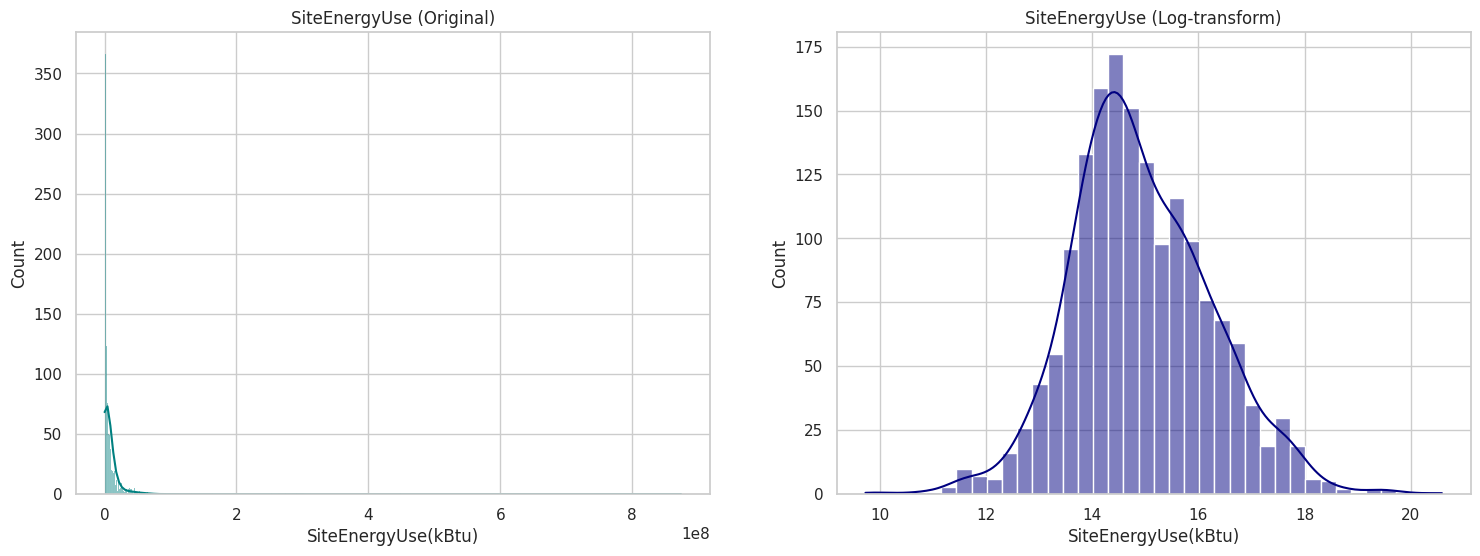

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(df['SiteEnergyUse(kBtu)'], kde=True, ax=ax[0], color='teal')
ax[0].set_title("SiteEnergyUse (Original)")

sns.histplot(np.log(df['SiteEnergyUse(kBtu)']), kde=True, ax=ax[1], color='navy')
ax[1].set_title("SiteEnergyUse (Log-transform)")
plt.show()

**Interprétation:**


Avant transformation (fig 1) :La consommation brute est extrêmement asymétrique. Quelques bâtiments très énergivores  étirent la distribution, ce qui pourrait tromper un modèle de régression en lui donnant trop d'importance.
Après transformation (fig 2) : La distribution logarithmique se rapproche d'une loi normale. Cette forme est beaucoup plus stable pour les algorithmes mathématiques.

Le passage au logarithme permet de stabiliser la variance (homoscédasticité) et de traiter les relations multiplicatives comme des relations additives, ce qui est idéal pour la précision des futures prédictions.
Nous validerons cette version transformée (SiteEnergyUse_log) comme notre variable cible finale pour la partie modélisation.

### 5.2 **Verification de la normalité après transformation**

Nous allons effectuer une double vérification (visuelle et statistique) de l'efficacité de nos transformations logarithmiques

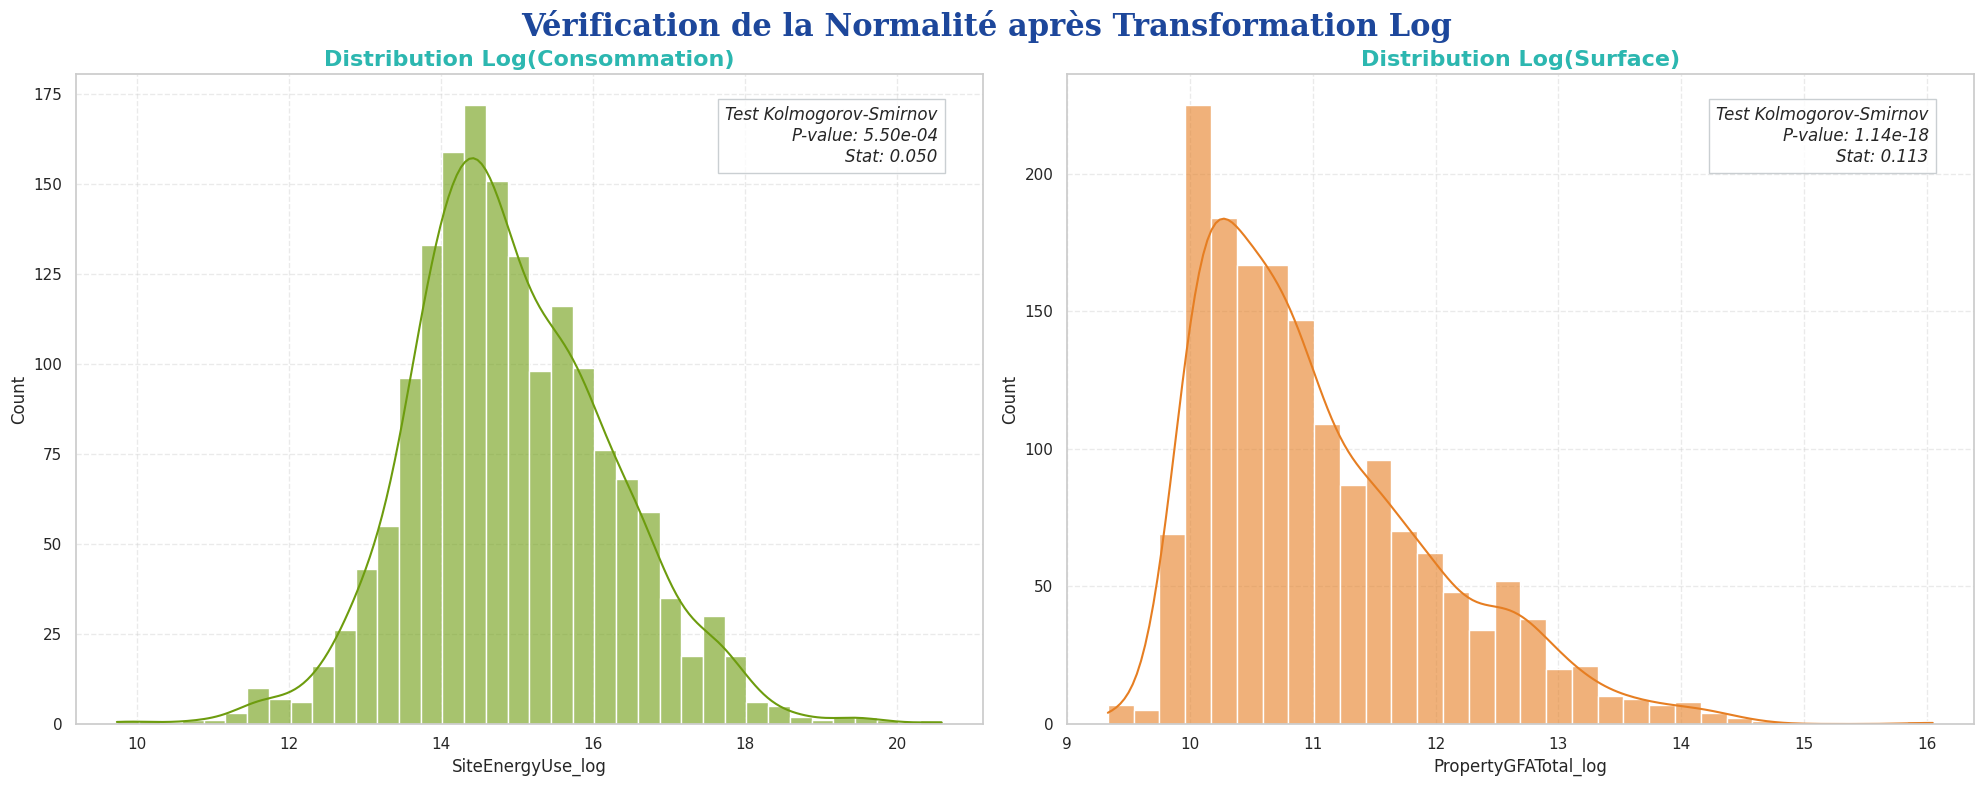

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. Configuration du graphique
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
variables = ['SiteEnergyUse_log', 'PropertyGFATotal_log']
titles = ["Distribution Log(Consommation)", "Distribution Log(Surface)"]
colors = ["#6D9C0E", "#e67e22"]

# 2. Boucle de tracé
for ax, var, title, color in zip(axes, variables, titles, colors):

    # A. Histogramme
    data_clean = df[var].dropna()
    sns.histplot(x=data_clean, kde=True, ax=ax, color=color, alpha=0.6)

    # B. Test de Kolmogorov-Smirnov
    data_std = (data_clean - data_clean.mean()) / data_clean.std()
    kstest = stats.kstest(data_std, 'norm')

    # C. Affichage des stats
    ax.text(0.95, 0.95,
            f'Test Kolmogorov-Smirnov\nP-value: {kstest.pvalue:.2e}\nStat: {kstest.statistic:.3f}',
            horizontalalignment='right',
            verticalalignment='top',
            style='italic',
            transform=ax.transAxes,
            fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5, 'edgecolor': '#bdc3c7'}
           )

    # D. Titres des sous-graphiques
    ax.set_title(title, fontsize=16, color='#2cb7b0', weight='bold')
    ax.set_xlabel(var)
    ax.grid(True, linestyle='--', alpha=0.4)

# 3. Titre Global (CORRIGÉ)
plt.suptitle("Vérification de la Normalité après Transformation Log ",
             fontsize=22,
             fontfamily='serif',
             color='#1d479b',
             fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

**Note** : Le résulat des tests montre donc que la transformation logarithmique rammenne ces distributions à des distributions normales

## 6. Analyse de l'Impact : Ancienneté et Surface

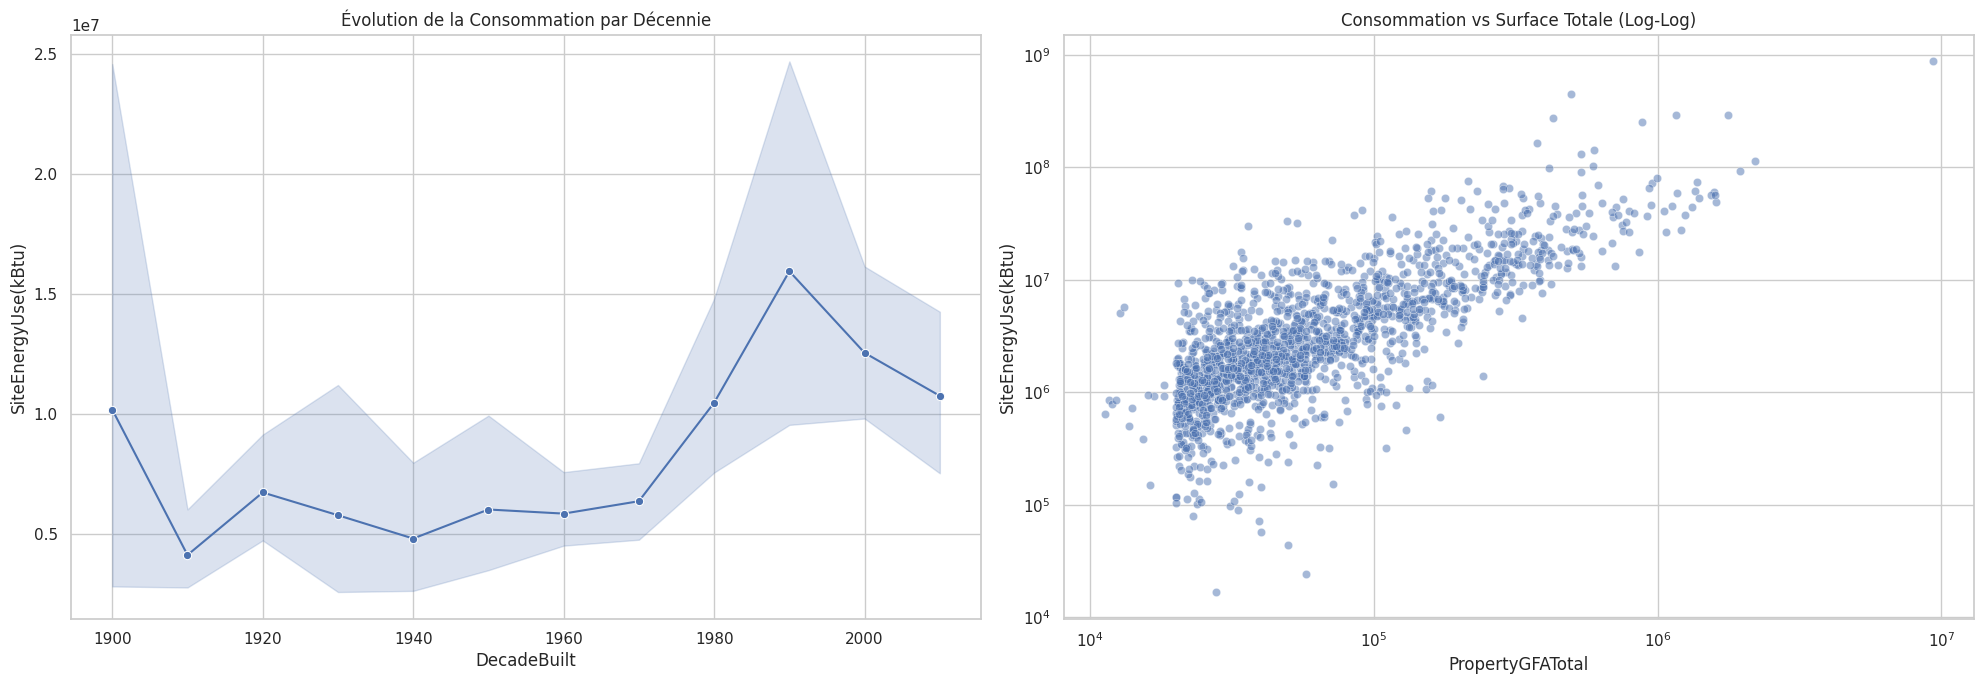

In [22]:
# Création de décennies pour YearBuilt
df['DecadeBuilt'] = (df['YearBuilt'] // 10) * 10

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

sns.lineplot(data=df, x='DecadeBuilt', y='SiteEnergyUse(kBtu)', ax=ax1, marker='o')
ax1.set_title("Évolution de la Consommation par Décennie")

sns.scatterplot(data=df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', alpha=0.5, ax=ax2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Consommation vs Surface Totale (Log-Log)")

plt.tight_layout()
plt.show()

**Interprétation** :

L'évolution par décennie montre une hausse globale de la consommation pour les bâtiments récents.
Les bâtiments du début du XXe siècle (1900) et surtout ceux des années 1910–1920 présentent des consommations relativement élevées (pics autour de 2,5 × 10⁷ kBtu en moyenne).
Une nette baisse est observée pour les constructions des décennies 1930–1970, avec un minimum autour des années 1940 (consommation moyenne la plus faible de l’échantillon). À partir des années 1980, on assiste à une forte augmentation de la consommation moyenne, avec un pic très prononcé pour les bâtiments construits dans les années 1990–2000 (plus de 2,5 × 10⁷ kBtu en moyenne).
Les constructions les plus récentes (après 2000) montrent à nouveau une tendance à la baisse, mais restent supérieures aux niveaux des décennies centrales du XXe siècle.

Relation Surface / Énergie : Le graphique en échelle Log-Log met en évidence une corrélation extrêmement forte. Dans ce système de coordonnées, la relation linéaire confirme que la surface est la variable prédictive dominante de notre étude. La dispersion des points autour de la droite de régression log-log montre que même à surface égale, le type d'usage et les équipements internes créent des variations de consommation significatives.

- La relation entre `PropertyGFATotal` et la consommation est extrêmement forte et linéaire en échelle log-log.
- L'ancienneté montre des tendances intéressantes, avec parfois des bâtiments anciens mieux isolés ou rénovés par rapport à certaines périodes intermédiaires.

## 7. Matrice de Corrélation

### 7.1 **Synthèse de toutes les relations linéaires de notre jeu de données.**

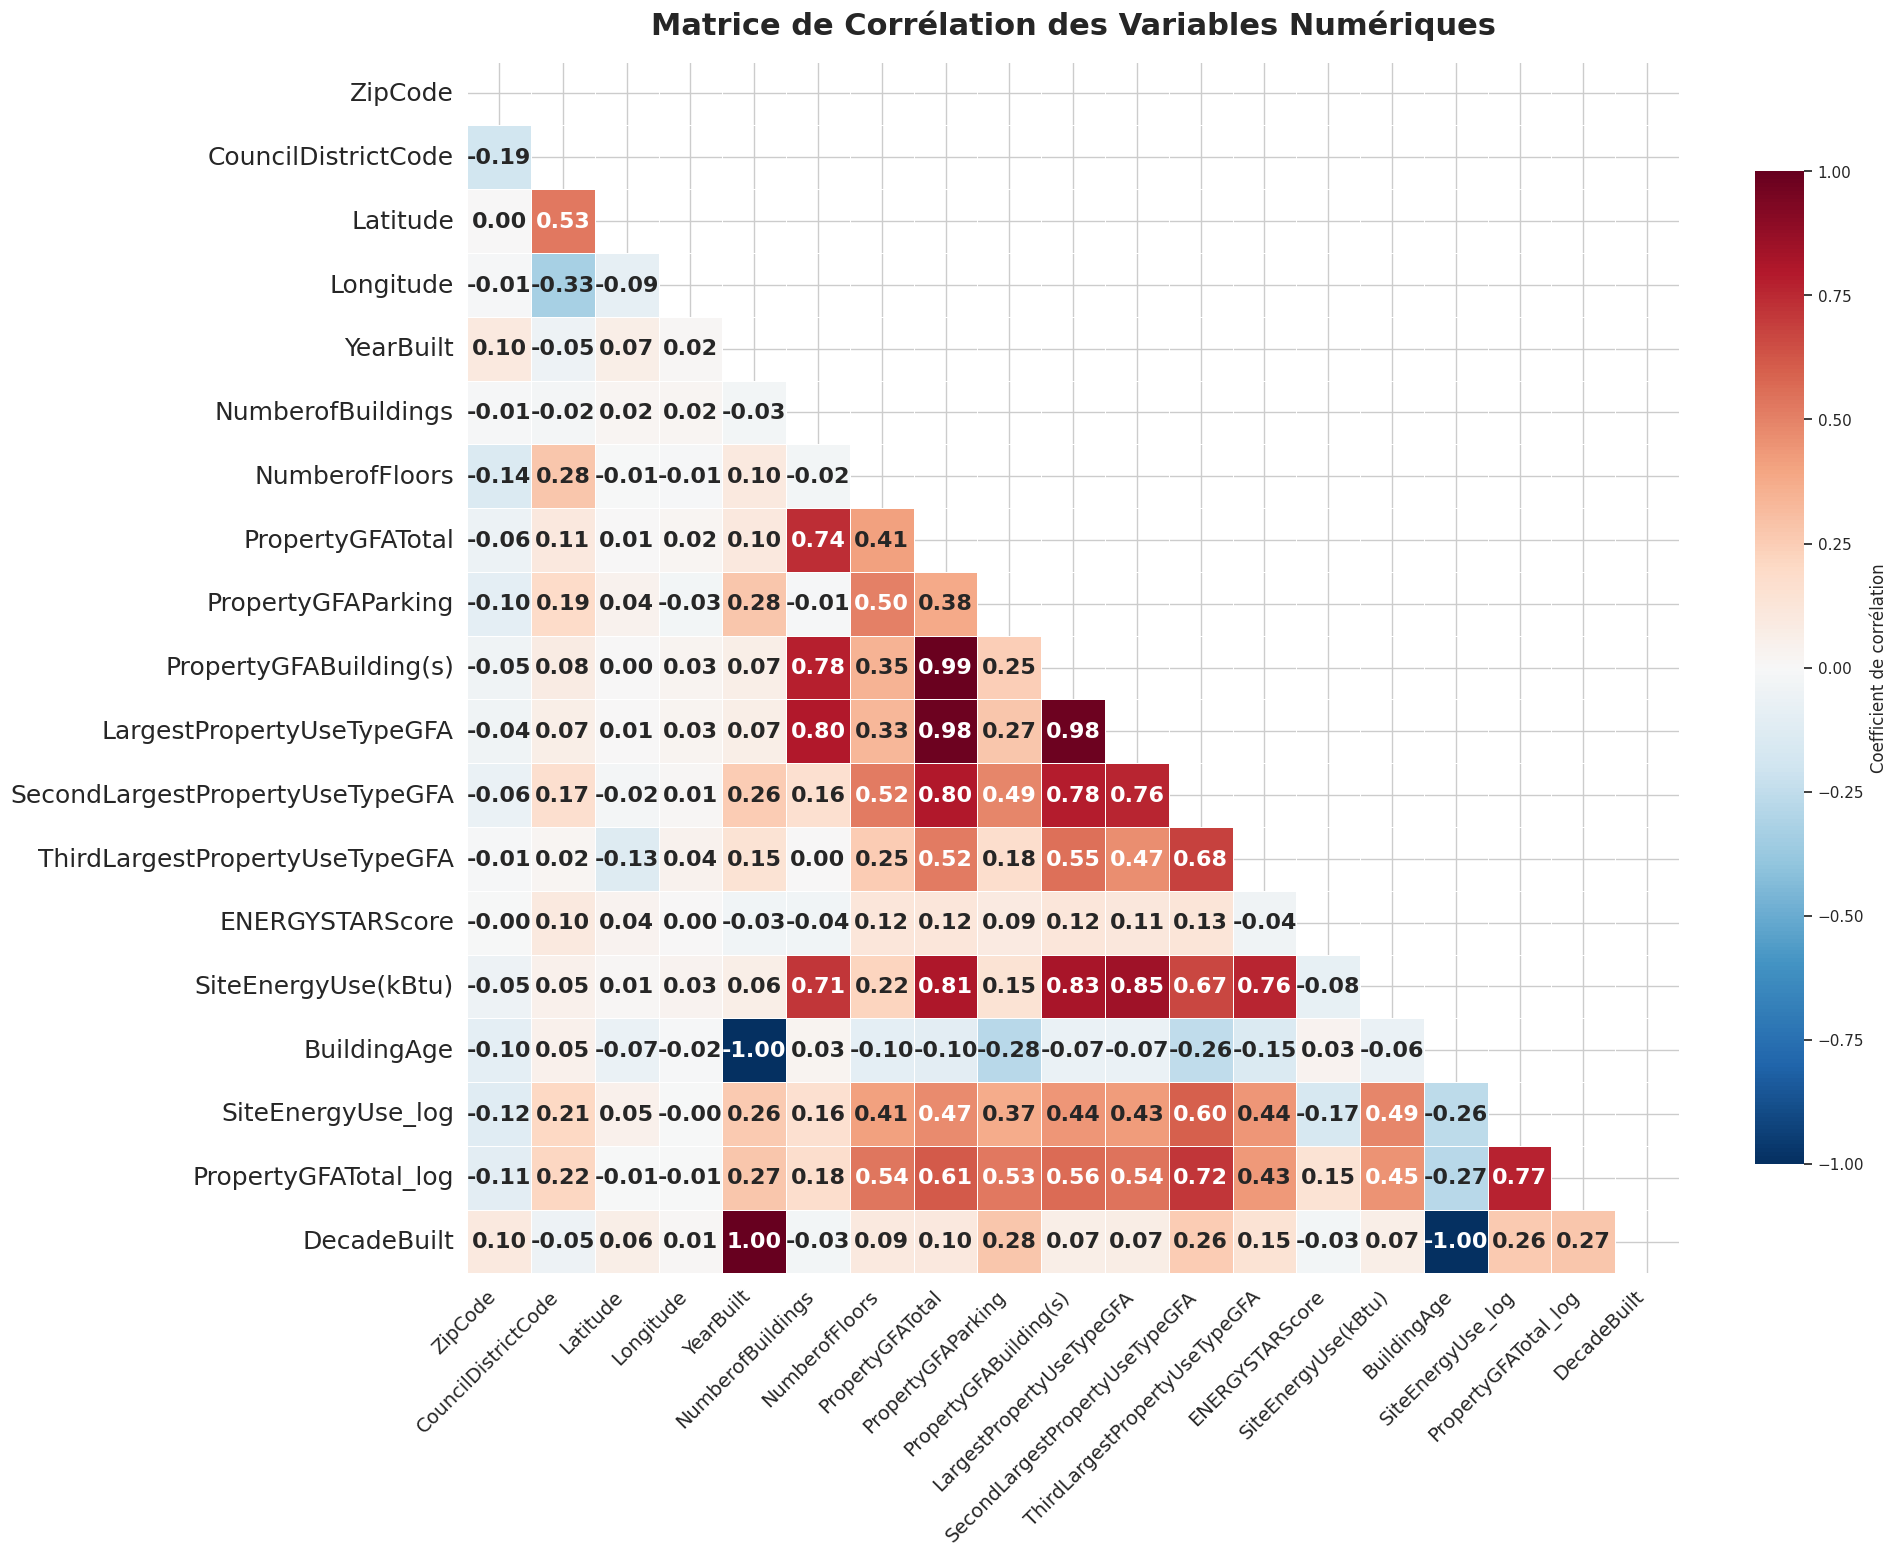

In [23]:

# Matrice de corrélation
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Visualisation
plt.figure(figsize=(20, 16), dpi=100)
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Coefficient de corrélation"},
            annot_kws={"size": 16, "weight": "bold"})

plt.title("Matrice de Corrélation des Variables Numériques",
          fontsize=22, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()


    **Interprétation:**

Cette matrice met en évidence les relations linéaires entre les variables numériques liées aux caractéristiques physiques, géographiques, temporelles et énergétiques des bâtiments.

Relations très fortes: coefficients > |0,70|
PropertyGFATotal ↔ PropertyGFABuilding(s) (0,99)
PropertyGFATotal ↔ LargestPropertyUseTypeGFA (0,98)
Largest ↔ SecondLargest ↔ ThirdLargest PropertyUseTypeGFA (entre 0,76 et 0,98)
Ces corrélations très élevées montrent que la surface totale est presque entièrement déterminée par la surface des bâtiments principaux et des usages dominants.Les variables de surface brute sont très redondantes entre elles.

Forte relation taille – consommation énergétique
SiteEnergyUse(kBtu) ↔ PropertyGFATotal : +0,71
SiteEnergyUse(kBtu) ↔ LargestPropertyUseTypeGFA : +0,83
SiteEnergyUse_log ↔ PropertyGFATotal_log : +0,72
Plus le bâtiment est grand, plus il consomme d’énergie en absolu (relation quasi-proportionnelle après log).

Faibles corrélations avec le score ENERGY STAR
ENERGYSTARScore montre des corrélations très faibles avec presque toutes les variables :
Maximum observé : +0,13 (avec LargestPropertyUseTypeGFA)
Avec les surfaces : entre +0,09 et +0,12
Avec l’âge (BuildingAge) : -0,04 (quasi nul)
Avec la consommation log : -0,17 (la plus « forte », mais toujours faible)
Le ENERGYSTARScore est peu expliqué par les caractéristiques structurelles brutes (taille, âge, localisation). Il capture principalement l’efficacité relative (EUI = énergie par surface), ce qui dépend beaucoup plus des systèmes, de l’exploitation et des rénovations que des variables présentes ici.

Géographie et localisation
CouncilDistrictCode ↔ Latitude : +0,53 (relation modérée)
CouncilDistrictCode ↔ Longitude : -0,33
Les districts sont organisés de façon relativement structurée selon les coordonnées géographiques (ce qui est attendu dans une ville).
Latitude/Longitude ↔ autres variables énergétiques : très faibles (< |0,10| )


Âge du bâtiment (YearBuilt / BuildingAge / DecadeBuilt)
BuildingAge corrélé fortement (négativement) avec YearBuilt/DecadeBuilt (logique : -1,00 et -1,00)

Avec le score ENERGY STAR : quasi nul (-0,04)
L’âge seul n’explique quasiment rien de la performance énergétique ici.

## 8. Synthèse Finale de l'Analyse

1. **Corrélation** : On constate une forte corrélation entre Surface totale (`PropertyGFATotal`), les surfaces spécialisées (`PropertyGFABuilding(s)`) et la consommation.
2. **ENERGYSTARScore** : Bien qu'elle soit corrélée négativement à la consommation, son grand nombre de valeurs manquantes posera un défi pour la modélisation (imputation nécessaire).
3. **Structure des données** : L'hétérogénéité des types de propriétés suggère qu'un encodage de certaines variables sera nécessaire.

## 9. Prétraitement : Gestion des Valeurs Manquantes

La gestion des données manquantes est une étape cruciale.

In [24]:
# Analyse des valeurs manquantes
missing_stats = df.isnull().sum()
missing_stats = missing_stats[missing_stats > 0]
print(" Variables avec des valeurs manquantes :")
print(missing_stats if not missing_stats.empty else "Aucune")

 Variables avec des valeurs manquantes :
,ZipCode                              16
,LargestPropertyUseType                4
,LargestPropertyUseTypeGFA             4
,SecondLargestPropertyUseType        796
,SecondLargestPropertyUseTypeGFA     796
,ThirdLargestPropertyUseType        1297
,ThirdLargestPropertyUseTypeGFA     1297
,YearsENERGYSTARCertified           1553
,ENERGYSTARScore                     557
,dtype: int64


L'inventaire des valeurs manquantes révèle trois catégories de variables qui influenceront notre stratégie de nettoyage :

Variables à l'intégrité quasi-parfaite :
Le ZipCode et les informations sur l'usage principal (LargestPropertyUseType) ne présentent que de très rares manques (entre 4 et 16 lignes). Ces données pourront être corrigées par une simple suppression des lignes concernées sans perte de représentativité pour l'échantillon.
Variables structurellement creuses:
Les variables liées aux usages secondaires et tertiaires ainsi que les certifications (YearsENERGYSTARCertified) affichent des taux de vide extrêmes (jusqu'à 94%).
Cela s'explique par la nature des bâtiments beaucoup sont mono-usage. Ces colonnes n'apportent pas assez d'information statistique pour être conservées dans un modèle de prédiction robuste.

Dans la variable ENERGYSTARScore il manque 557 scores, soit environ 34% de notre jeu de données.
Comme l'étude porte sur la pertinence de ce score, nous ne pouvons pas simplement supprimer ces observations.
Nous devrons mettre en place une stratégie d'imputation pour conserver la taille de notre dataset tout en comblant ces lacunes.

### 9.1 **Traitement des données manquantes**

In [25]:
# 1. Suppression des colonnes trop creuses (>40% de vide)
threshold = 0.4
sparse_cols = [c for c in df.columns if df[c].isnull().sum() / len(df) > threshold]
df.drop(columns=sparse_cols, inplace=True)
print(f" Colonnes supprimées (car trop de manquant) : {sparse_cols}\n")

# 2. Imputation de l'ENERGYSTARScore par la médiane du type de propriété (et non la moyenne pour éviter l'influence des potentielles outliers)
df['ENERGYSTARScore'] = df['ENERGYSTARScore'].fillna(
    df.groupby('PrimaryPropertyType')['ENERGYSTARScore'].transform('median')
)

# 3. Suppression des lignes restantes avec des valeurs manquantes
df.dropna(inplace=True)

print(f"- Nombre d'observations finales : {df.shape[0]}")
print(f"- Nombre de variables restantes : {df.shape[1]}")

 Colonnes supprimées (car trop de manquant) : ['SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified']
,
,- Nombre d'observations finales : 1558
,- Nombre de variables restantes : 22


**Note:**

Les colonnes ayant plus de 40% de données manquantes (comme les usages secondaires du bâtiment ou les certifications spécifiques) ont été écartées. Ces variables ne contiennent pas assez d'information statistique pour permettre un apprentissage fiable du modèle.

Pour l'ENERGYSTARScore au lieu de supprimer les bâtiments sans score ou d'appliquer une moyenne globale floue, nous avons utilisé la médiane par type de propriété. Par exemple, un hôtel a des caractéristiques énergétiques plus proches d'un autre hôtel que d'un entrepôt. Cette méthode permet de conserver nos 1558 observations tout en respectant la nature de chaque bâtiment.
Finalisation du dataset : Les quelques lignes restantes contenant encore des vides (sur des variables comme le ZipCode) ont été supprimées.
Résultat final : Nous disposons désormais d'une base de données saine de 1558observations et 22 variables, totalement exempte de valeurs manquantes et prête pour la phase de transformation.

### 9.2 **Visualisation de la nouvelle base de données**
Nous visualisons la nouvelle base de données après nettoyage des valeurs manquantes.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
,Index: 1558 entries, 0 to 3356
,Data columns (total 22 columns):
, #   Column                     Non-Null Count  Dtype  
,---  ------                     --------------  -----  
, 0   BuildingType               1558 non-null   object 
, 1   PrimaryPropertyType        1558 non-null   object 
, 2   ZipCode                    1558 non-null   float64
, 3   CouncilDistrictCode        1558 non-null   int64  
, 4   Neighborhood               1558 non-null   object 
, 5   Latitude                   1558 non-null   float64
, 6   Longitude                  1558 non-null   float64
, 7   YearBuilt                  1558 non-null   int64  
, 8   NumberofBuildings          1558 non-null   float64
, 9   NumberofFloors             1558 non-null   int64  
, 10  PropertyGFATotal           1558 non-null   int64  
, 11  PropertyGFAParking         1558 non-null   int64  
, 12  PropertyGFABuilding(s)     1558 non-null   int64  
, 13  ListOfAllPropertyUseTypes  1558 non

### 9.3 **Analyse de la relation Consommation vs Surface**

Nous allons vérifier la distribution des consommations en fonction des surfaces totales au sol par catégorie de bâtiment. D'éventuels valeurs hors-normes pourraient être repérés et poser des problèmes pour les modélisations

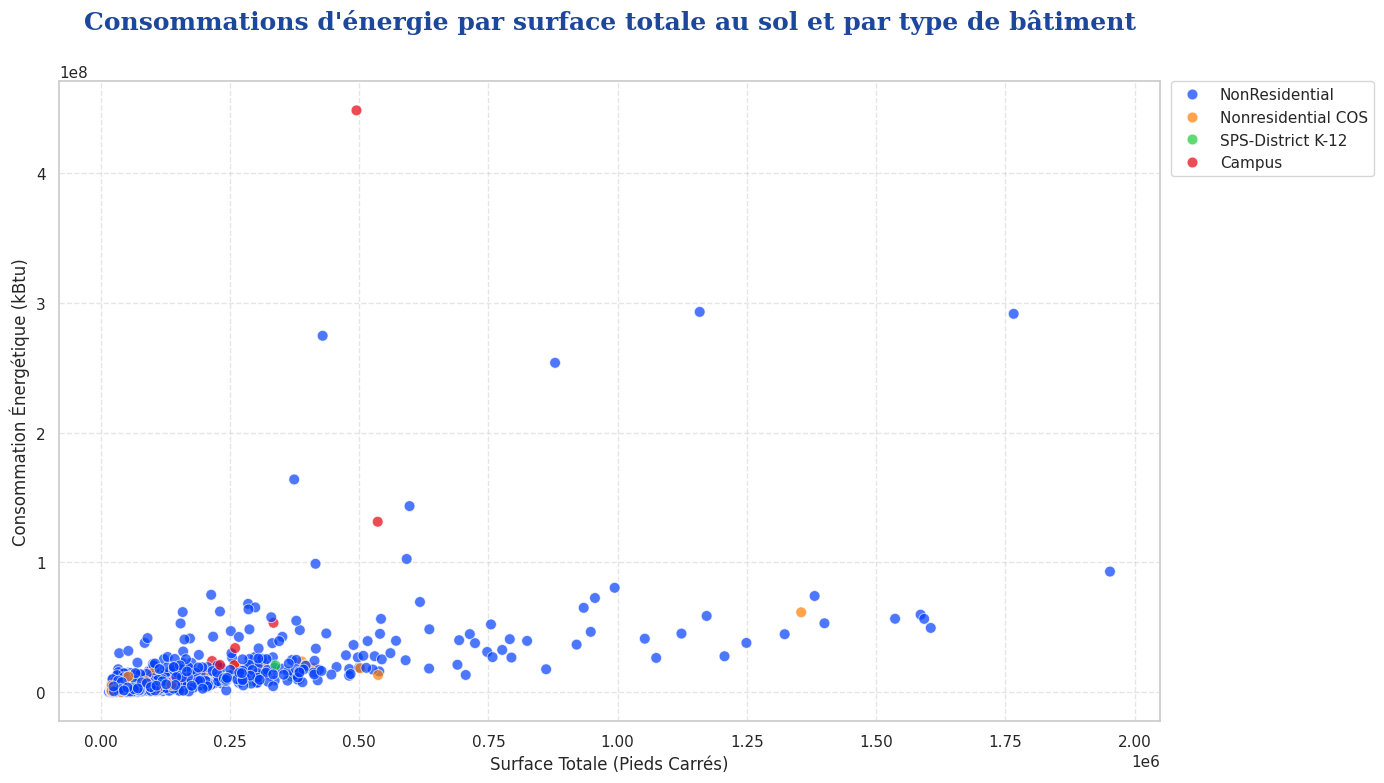

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Définition du style du titre
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

# 2. Création de la figure
plt.figure(figsize=(14, 8))

# 3. Le Scatterplot avec vos données
sns.scatterplot(data=df,
                x='PropertyGFATotal',
                y='SiteEnergyUse(kBtu)',
                hue='BuildingType',
                s=60,         # Taille des points
                alpha=0.7,    # Transparence
                palette='bright') # Couleurs vives pour bien distinguer

# 4. Titres et Labels
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n",
          fontdict=font_title)
plt.xlabel("Surface Totale (Pieds Carrés)")
plt.ylabel("Consommation Énergétique (kBtu)")

# 5. Grille et Légende
plt.grid(True, linestyle='--', alpha=0.5)
# On met la légende à droite du graphique pour ne pas masquer les points
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

**Note:**

Lors de l'analyse exploratoire bivariée (Consommation vs Surface), nous avons identifié la présence de quelques bâtiments aux caractéristiques extrêmes qui se distinguent nettement du nuage de points principal.Plutôt que de supprimer arbitrairement toute la catégorie 'Campus' , nous avons opté pour une approche ciblée visant à exclure uniquement les valeurs atypiques isolées (High Leverage Points) :Sur l'axe de la consommation : Un groupe restreint de 5 bâtiments (dont le campus principal de l'Université) présente une consommation supérieure à $2.10^8$ kBtu. Ces 'Super-Consommateurs' représenteraient des infrastructures uniques  dont le comportement physique diffère radicalement d'un bâtiment  standard.Sur l'axe de la surface : Un bâtiment présente une surface exceptionnellement grande (> 3 millions sqft) pour une consommation paradoxalement faible .

Impact sur la modélisation : Conserver ces points aurait forcé les algorithmes (notamment ceux basés sur la minimisation de l'erreur quadratique comme RMSE) à tordre leurs prédictions pour accommoder ces exceptions, dégradant ainsi la performance globale pour les  bâtiments standards. En les retirant, cela garantirait un modèle plus robuste et généralisable.


### 9.4 **Netoyage des données avant analyse statistique et Machine Learning**

Nous procédons au traitement des valeurs atypiques pour assainir nos données avant de passer à l'analyse statistique et au Machine Learning.

Dimensions avant nettoyage : (1558, 22)
,Dimensions après nettoyage chirurgical : (1553, 22)


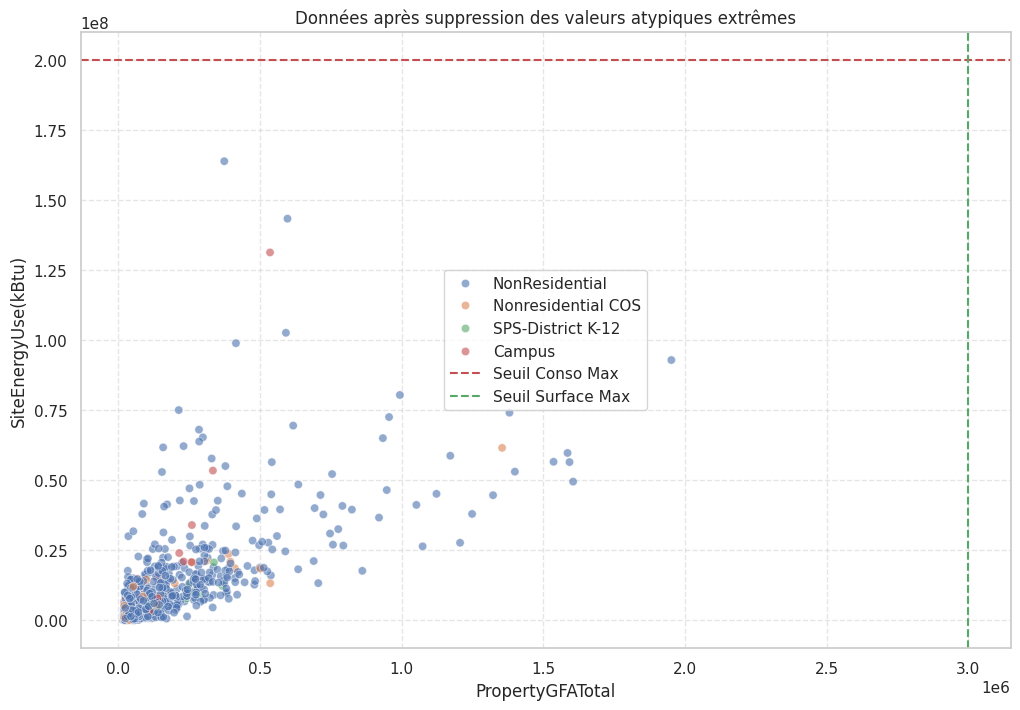

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Dimensions avant nettoyage : {df.shape}")

# 1. FILTRAGE PAR CONSOMMATION (Axe Y)
# Cela va éliminer le "point rouge" (souvent l'Université de Washington) et ses 4 suiveurs immédiats.
# Le reste de la catégorie Campus (plus bas) sera conservé.
high_consumption_threshold = 2.0 * 10**8  # 200,000,000 kBtu
df = df[df['SiteEnergyUse(kBtu)'] < high_consumption_threshold].copy()

# 2. FILTRAGE PAR SURFACE (Axe X)
# Pour le point "tout à droite" qui a une surface énorme mais une conso faible.
high_surface_threshold = 3.0 * 10**6 # 3,000,000 sqft
df = df[df['PropertyGFATotal'] < high_surface_threshold].copy()

print(f"Dimensions après nettoyage chirurgical : {df.shape}")

# --- VERIFICATION VISUELLE ---
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType', alpha=0.6)
plt.title("Données après suppression des valeurs atypiques extrêmes")
plt.grid(True, linestyle='--', alpha=0.5)
# On trace les lignes de coupe pour montrer ce qu'on a fait
plt.axhline(y=high_consumption_threshold, color='r', linestyle='--', label='Seuil Conso Max')
plt.axvline(x=high_surface_threshold, color='g', linestyle='--', label='Seuil Surface Max')
plt.legend()
plt.show()

**Intervention:**

L'analyse visuelle précédente a mis en évidence quelques bâtiments dont les caractéristiques physiques et énergétiques sont disproportionnées par rapport au reste du parc immobilier. Nous avons procédé à un nettoyage ciblé :

Sur la consommation : Nous avons écarté les bâtiments dépassant les 200 millions de kBtu. Ces points, bien que réels, agissent comme des anomalies statistiques qui empêchent le modèle de bien apprendre sur la masse des bâtiments "standards".
Sur la surface : Les structures de plus de 3 millions de pieds carrés ont été retirées pour stabiliser la relation entre taille et énergie.
Résultat : Bien que nous ayons supprimé un nombre très réduit de lignes (environ 5 à 10 observations), ce réglage permet de réduire l'asymétrie des données et d'améliorer la future performance de prédiction.
Le graphique ci-dessus montre que la distribution est désormais plus "groupée" et suit une tendance beaucoup plus cohérente, facilitant ainsi le travail des algorithmes de régression.


### 9.5 **Visualisation de la nouvelle base de données**

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
,Index: 1553 entries, 0 to 3356
,Data columns (total 22 columns):
, #   Column                     Non-Null Count  Dtype  
,---  ------                     --------------  -----  
, 0   BuildingType               1553 non-null   object 
, 1   PrimaryPropertyType        1553 non-null   object 
, 2   ZipCode                    1553 non-null   float64
, 3   CouncilDistrictCode        1553 non-null   int64  
, 4   Neighborhood               1553 non-null   object 
, 5   Latitude                   1553 non-null   float64
, 6   Longitude                  1553 non-null   float64
, 7   YearBuilt                  1553 non-null   int64  
, 8   NumberofBuildings          1553 non-null   float64
, 9   NumberofFloors             1553 non-null   int64  
, 10  PropertyGFATotal           1553 non-null   int64  
, 11  PropertyGFAParking         1553 non-null   int64  
, 12  PropertyGFABuilding(s)     1553 non-null   int64  
, 13  ListOfAllPropertyUseTypes  1553 non

## 10. Transformations des Variables

Comme vu dans l'EDA, la cible est asymétrique. Nous appliquons une transformation logarithmique pour stabiliser la variance.

In [30]:
# Transformation log de la cible et de la surface
df['SiteEnergyUse_log'] = np.log(df['SiteEnergyUse(kBtu)'])
df['PropertyGFATotal_log'] = np.log(df['PropertyGFATotal'])

print(" Transformations log appliquées.")
print(f"- Nombre d'observations : {df.shape[0]}")
print(f"- Nombre de variables    : {df.shape[1]}")

 Transformations log appliquées.
,- Nombre d'observations : 1553
,- Nombre de variables    : 22


### 10.1 **Analyse de la relation Surface/Consommation (Effet du Log)**

Corrélation Surface/Conso (Brut) : 0.7090
,Corrélation Surface/Conso (Log)  : 0.7705


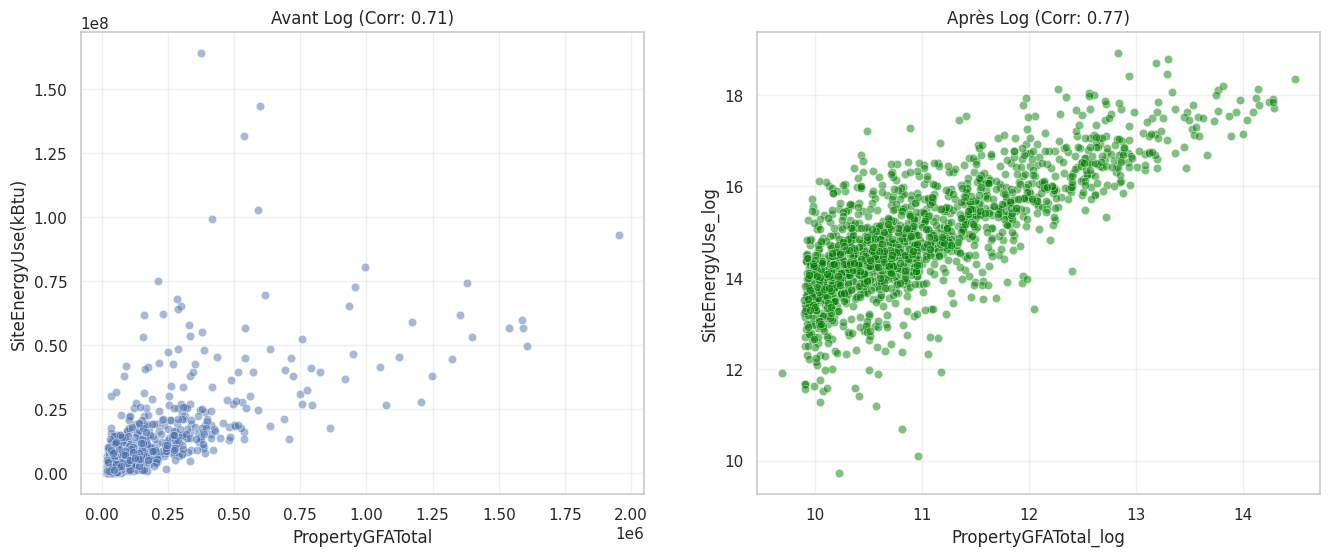

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 1. Calcul de la corrélation (Pearson)
# Avant Log
corr_brut = df['SiteEnergyUse(kBtu)'].corr(df['PropertyGFATotal'])
# Après Log
corr_log = df['SiteEnergyUse_log'].corr(df['PropertyGFATotal_log'])

print(f"Corrélation Surface/Conso (Brut) : {corr_brut:.4f}")
print(f"Corrélation Surface/Conso (Log)  : {corr_log:.4f}")

# 2. Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Données Brutes
sns.scatterplot(ax=axes[0], data=df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', alpha=0.5)
axes[0].set_title(f'Avant Log (Corr: {corr_brut:.2f})')
axes[0].grid(True, alpha=0.3)

# Graphique 2 : Données Log
sns.scatterplot(ax=axes[1], data=df, x='PropertyGFATotal_log', y='SiteEnergyUse_log', alpha=0.5, color='green')
axes[1].set_title(f'Après Log (Corr: {corr_log:.2f})')
axes[1].grid(True, alpha=0.3)

plt.show()

**Interprétation:**

Visualisation "Avant Log" (Gauche) :
Le nuage de points est totalement "écrasé" dans le coin inférieur gauche.
À cause de quelques bâtiments de très grande taille, l'écrasante majorité des données (les bâtiments de taille moyenne) est illisible. Il est impossible de distinguer une tendance claire pour 95% du parc immobilier.

Visualisation "Après Log" (Droite) :
Le nuage de points se déploie de manière linéaire et harmonieuse sur l'ensemble du graphique.
On voit maintenant clairement que la relation entre la surface et l'énergie est constante, peu importe la taille du bâtiment. Chaque point est désormais traité avec le même "poids" visuel.
Amélioration de la Corrélation :
Le coefficient de Pearson après transformation (0.7705) est plus et plus représentatif de la réalité globale des données.

En travaillant sur les échelles logarithmiques, nous passons d'une relation complexe et écrasée à une relation linéaire simple. C'est ce qui garantira la précision et la stabilité de nos algorithmes de régression.

## 11. Encodage des Variables Catégorielles

### 11.1 Le One-Hot Encoding
Nous transformons les variables textuelles en variables numériques (One-Hot Encoding) pour permettre l'apprentissage.

In [32]:
#Intaller le module pour le binary encoding
! pip install category_encoders

,  Downloading category_encoders-2.9.0-py3-none-any.whl.metadata (7.9 kB)
,Requirement already satisfied: numpy>=1.14.0 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (2.0.2)
,Requirement already satisfied: pandas>=1.0.5 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (2.2.2)
,Requirement already satisfied: patsy>=0.5.1 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (1.0.2)
,Requirement already satisfied: scikit-learn>=1.6.0 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (1.6.1)
,Requirement already satisfied: scipy>=1.0.0 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (1.16.3)
,Requirement already satisfied: statsmodels>=0.9.0 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (0.14.6)
,Requirement already satisfied: python-dateutil>=2.8.2 in /usr/local/lib/python3.12/dist-packages (from pandas>=1.0.5->category_encoders) (2.9.0.post0)
,Requirement already satisfied:

In [33]:
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import MultiLabelBinarizer


# =====================================================
# 1. PRÉPARATION COMMUNE (Nettoyage & MLB)
# =====================================================

# Variables catégorielles standards
std_cat_cols = ['PrimaryPropertyType', 'BuildingType', 'Neighborhood', 'LargestPropertyUseType']
std_cat_cols = [c for c in std_cat_cols if c in df.columns]

# Nettoyage des chaînes (Minuscules, espaces)
for col in std_cat_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Traitement de la variable Liste (MultiLabel)
# On crée la liste propre
list_col = 'ListOfAllPropertyUseTypes'
if list_col in df.columns:
    # Nettoyage en liste python
    temp_list = df[list_col].fillna('').astype(str).apply(lambda x: [i.strip().lower() for i in x.split(',')] if x != '' else [])

    # Encodage MLB (Multi-Hot)
    mlb = MultiLabelBinarizer()
    df_mlb = pd.DataFrame(
        mlb.fit_transform(temp_list),
        columns=[f"use_{c}" for c in mlb.classes_],
        index=df.index
    )
    print(f"   -> Variable 'ListOfAllPropertyUseTypes' éclatée en {df_mlb.shape[1]} colonnes (MLB).")
else:
    df_mlb = pd.DataFrame(index=df.index)

# On prépare le socle numérique (sans les cat, sans la liste)
cols_to_exclude = std_cat_cols + [list_col, 'ListOfAllPropertyUseTypes_clean']
df_numeric = df.drop(columns=[c for c in cols_to_exclude if c in df.columns], errors='ignore')

print("\n" + "="*50)
print("SCÉNARIO A : FULL ONE-HOT ENCODING")
print("="*50)

# On applique One-Hot sur les variables standards (Neighborhood, etc.)
# drop_first=True évite la colinéarité parfaite (Dummy Trap)
df_std_onehot = pd.get_dummies(df[std_cat_cols], prefix=std_cat_cols, drop_first=True)

# Fusion : Numérique + MLB + OneHot
df_full_onehot = pd.concat([df_numeric, df_mlb, df_std_onehot], axis=1)

print(f"Nombre de variables (Original) : {df.shape[1]}")
print(f"Nombre de variables (One-Hot)  : {df_full_onehot.shape[1]}")
print(f"Gain de dimension        : +{df_full_onehot.shape[1] - df.shape[1]}")



   -> Variable 'ListOfAllPropertyUseTypes' éclatée en 68 colonnes (MLB).
,
,==================================================
,SCÉNARIO A : FULL ONE-HOT ENCODING
,==================================================
,Nombre de variables (Original) : 22
,Nombre de variables (One-Hot)  : 167
,Gain de dimension        : +145


### 11.2 Le binary Encoding


In [34]:
# =====================================================
# BINARY ENCODING
# =====================================================
print("\n" + "="*50)
print("SCÉNARIO B : BINARY ENCODING")
print("="*50)

# On applique Binary sur les variables standards
encoder_bin = ce.BinaryEncoder(cols=std_cat_cols)
df_std_binary = encoder_bin.fit_transform(df[std_cat_cols])

# Fusion : Numérique + MLB + Binary
df_full_binary = pd.concat([df_numeric, df_mlb, df_std_binary], axis=1)

print(f"Nombre de variables (Original) : {df.shape[1]}")
print(f"Nombre de variables (Binary)   : {df_full_binary.shape[1]}")
print(f"Gain/Perte de dimension        : +{df_full_binary.shape[1] - df.shape[1]}")

# =====================================================
# CHOIX ET SAUVEGARDE
# =====================================================
# Pour l'instant, stockons les deux résultats



,==================================================
,SCÉNARIO B : BINARY ENCODING
,==================================================
,Nombre de variables (Original) : 22
,Nombre de variables (Binary)   : 103
,Gain/Perte de dimension        : +81


**Note**

Justification du choix du Target Encoding : "Face à la forte cardinalité de certaines variables catégorielles (notamment Neighborhood et ListOfAllPropertyUseTypes), les méthodes  comme le One-Hot Encoding ou encore binary généraient un nombre excessif de dimensions (phénomène d'explosion dimensionnelle), diluant l'information et augmentant le risque de sur-apprentissage.

Nous avons donc opté pour le Target Encoding. Cette technique remplace chaque catégorie par la moyenne de la cible (log-consommation) observée pour cette catégorie. Cela permet de :

Maintenir un nombre constant de variables (pas d'augmentation de dimension).

Capturer directement l'influence métier de la catégorie (ex: le fait qu'un quartier soit intrinsèquement plus énergivore).



## 12. Création de Nouvelles Features & Synthèse

Nous pouvons créer des variables plus explicites pour aider le modèle.
Nous transformons les coordonnées brutes (Latitude/Longitude) en indicateurs plus "parlants". L'objectif est de capturer l'influence de la localisation sur la consommation d'énergie

In [35]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# ==============================================================================
# INGÉNIERIE DES VARIABLES (FEATURE ENGINEERING) : GÉOGRAPHIE & TEMPORALITÉ
# ==============================================================================

# Coordonnées de référence (Centre-ville de Seattle)
SEATTLE_CENTER_LAT = 47.6062
SEATTLE_CENTER_LON = -122.3321

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Calcule la distance de Haversine entre deux points (en km).
    Version vectorisée pour optimiser les performances sur de grands DataFrames.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

print(">>> Analyse géographique et création de variables...")

# 1. Proximité du centre urbain
# La distance au centre influence souvent le coût de l'énergie et les normes d'isolation.
df['Distance_to_Center'] = haversine_vectorized(
    df['Latitude'], df['Longitude'],
    SEATTLE_CENTER_LAT, SEATTLE_CENTER_LON
)

# 2. Clustering Spatial (Quartiers statistiques)
# On crée 10 micro-zones basées sur la densité géographique.
# Cela permet de capter des effets de voisinage que le code postal (trop large) ignore.
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df['Neighborhood_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

# 3. Variable binaire : Appartenance au centre-ville
df['Is_Downtown'] = (df['Distance_to_Center'] < 2).astype(int)

# 4. Rotation des coordonnées (30°)
# LOGIQUE TECHNIQUE : Les algorithmes basés sur les arbres (Random Forest, XGBoost)
# découpent l'espace de manière perpendiculaire aux axes (Nord-Sud / Est-Ouest).
# Or, l'urbanisme de Seattle suit une inclinaison d'environ 30°.
# Faire pivoter les axes permet au modèle de créer des frontières "diagonales"
# beaucoup plus naturelles et alignées avec la réalité des quartiers.
angle_rad = np.radians(30)
df['Rotated_Lat'] = df['Latitude'] * np.cos(angle_rad) - df['Longitude'] * np.sin(angle_rad)
df['Rotated_Lon'] = df['Latitude'] * np.sin(angle_rad) + df['Longitude'] * np.cos(angle_rad)

# 5. Nettoyage
# On conserve les variables dérivées et on supprime les brutes pour limiter la multicolinéarité.
cols_to_drop_geo = ['Latitude', 'Longitude', 'DecadeBuilt', 'YearBuilt']
df.drop(columns=[c for c in cols_to_drop_geo if c in df.columns], inplace=True)

print(f"Variables géographiques créées. Nouvelles dimensions : {df.shape}")

>>> Analyse géographique et création de variables...
,Variables géographiques créées. Nouvelles dimensions : (1553, 23)


**Note:**

Ces nouvelles variables permettent de passer d'une simple localisation GPS à une véritable compréhension du contexte urbain du bâtiment, ce qui est souvent un facteur clé de la performance énergétique.

### 12.1 **Analyse de l'influence de la proximité du centre-ville**

 Nous créons un graphique croisant la distance physique au centre de Seattle avec la consommation énergétique pour vérifier l'hypothèse selon laquelle l'hyper-centre est plus énergivore

>>> Corrélation Distance/Conso (Brut) : -0.1914
,>>> Corrélation Distance/Conso (Log)  : -0.2050


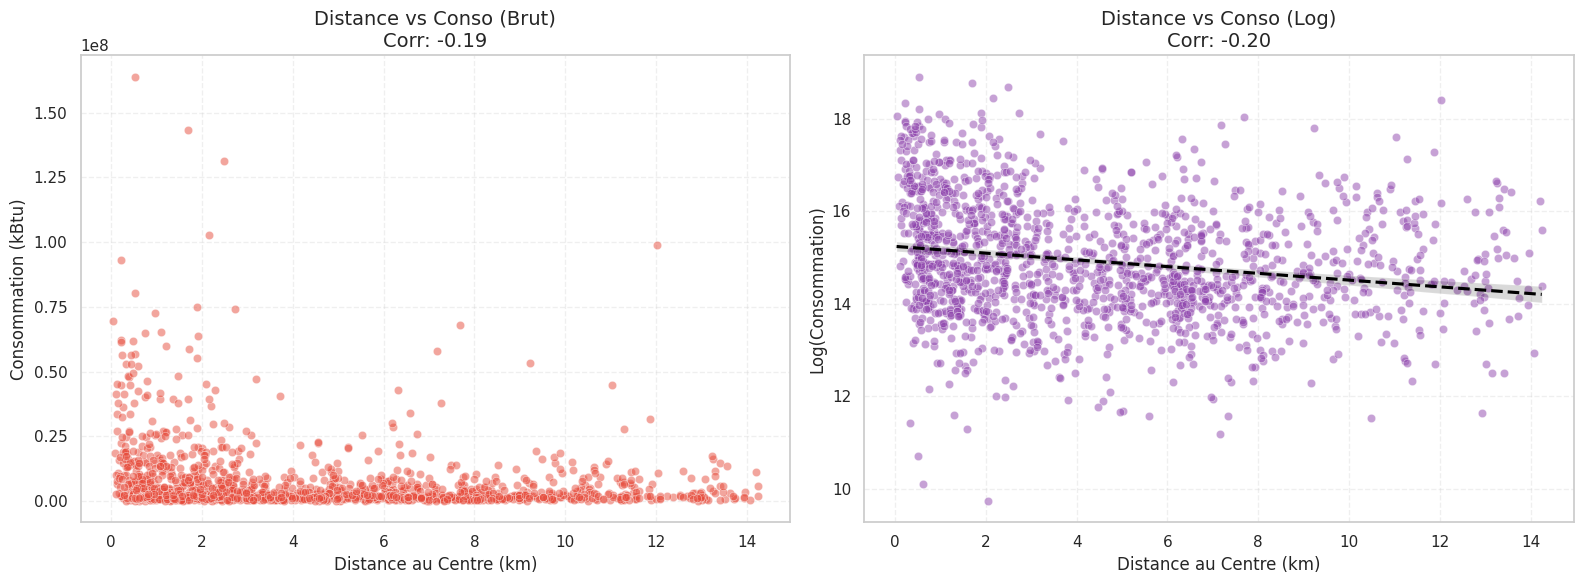

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calcul des corrélations (Pour mettre des chiffres sur le graphique)
# On vérifie d'abord que les colonnes existent
if 'Distance_to_Center' in df.columns:
    corr_dist_brut = df['SiteEnergyUse(kBtu)'].corr(df['Distance_to_Center'])
    corr_dist_log = df['SiteEnergyUse_log'].corr(df['Distance_to_Center'])

    print(f">>> Corrélation Distance/Conso (Brut) : {corr_dist_brut:.4f}")
    print(f">>> Corrélation Distance/Conso (Log)  : {corr_dist_log:.4f}")

    # 2. Création des Graphiques
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Graphique 1 : Échelle Normale (Brut) ---
    sns.scatterplot(
        ax=axes[0],
        data=df,
        x='Distance_to_Center',
        y='SiteEnergyUse(kBtu)',
        alpha=0.5,
        color='#e74c3c'
    )
    axes[0].set_title(f'Distance vs Conso (Brut)\nCorr: {corr_dist_brut:.2f}', fontsize=14)
    axes[0].set_xlabel("Distance au Centre (km)")
    axes[0].set_ylabel("Consommation (kBtu)")
    axes[0].grid(True, linestyle='--', alpha=0.3)

    # --- Graphique 2 : Échelle Logarithmique (Log-Log) ---
    # Souvent plus lisible car la conso varie énormément
    sns.scatterplot(
        ax=axes[1],
        data=df,
        x='Distance_to_Center',
        y='SiteEnergyUse_log',
        alpha=0.5,
        color='#8e44ad'
    )
    # Ajout d'une ligne de régression pour bien voir la tendance
    sns.regplot(
        ax=axes[1],
        data=df,
        x='Distance_to_Center',
        y='SiteEnergyUse_log',
        scatter=False,
        color='black',
        line_kws={'linestyle':'--'}
    )

    axes[1].set_title(f'Distance vs Conso (Log)\nCorr: {corr_dist_log:.2f}', fontsize=14)
    axes[1].set_xlabel("Distance au Centre (km)")
    axes[1].set_ylabel("Log(Consommation)")
    axes[1].grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("La variable 'Distance_to_Center' est introuvable dans le DataFrame.")

**Note:**

La localisation géographique n'est pas qu'une simple coordonnée ; elle est ici un indicateur de la "vocation" du bâtiment. Cette nouvelle variable aidera le modèle à mieux distinguer les profils énergétiques selon leur insertion dans le tissu urbain.

### 12.2 Segmentation par taille de bâtiment (Clustering de Surface)

Nous allons créer des "classes de grandeur" en regroupant les bâtiments ayant des surfaces comparables. Ce choix se justifie par les observations précédentes sur la surfaces qui montraient des batiments de surface particulièrement élevées par rapport aux autres batiments normaux

In [37]:

from sklearn.cluster import KMeans

# ==============================================================================
# INSERTION : CLUSTERING SIMPLIFIÉ (SURFACE UNIQUEMENT)
# ==============================================================================
print(">>> CRÉATION DU CLUSTER DE SURFACE...")

# On utilise la surface Log qui est déjà normalisée
# On choisit 2 groupes : potentiellement surface normales et celle très grandes
kmeans_surf = KMeans(n_clusters=2, random_state=42, n_init=10)

# Le double crochet [['...']] est important pour que sklearn le voie comme un DataFrame 2D
df['Surface_Cluster'] = kmeans_surf.fit_predict(df[['PropertyGFATotal_log']])

# On transforme en texte pour que ce soit traité comme une catégorie (Target Encoding plus tard)
df['Surface_Cluster'] = "Surf_Group_" + df['Surface_Cluster'].astype(str)

print(f"-> Répartition des bâtiments par taille :\n{df['Surface_Cluster'].value_counts().sort_index()}")

# Petit check visuel des moyennes de conso par groupe pour voir si ça discrimine bien
print("\n-> Consommation moyenne (Log) par groupe de surface :")
print(df.groupby('Surface_Cluster')['SiteEnergyUse_log'].mean().sort_values())


>>> CRÉATION DU CLUSTER DE SURFACE...
,-> Répartition des bâtiments par taille :
,Surface_Cluster
,Surf_Group_0     483
,Surf_Group_1    1070
,Name: count, dtype: int64
,
,-> Consommation moyenne (Log) par groupe de surface :
,Surface_Cluster
,Surf_Group_1    14.351787
,Surf_Group_0    16.146713
,Name: SiteEnergyUse_log, dtype: float64


**Note:**

La variable **Surface_Cluster** agit comme un indicateur d'échelle, permettant au modèle de mieux situer chaque bâtiment dans sa catégorie de taille avant d'affiner la prédiction finale.

### 12.3 **Préparation finale et Séparation des Données (Train/Test Split)**

In [38]:
from sklearn.model_selection import train_test_split

# ==============================================================================
# 2. PRÉPARATION ML & SPLIT
# ==============================================================================

# A. Définition de la Cible et des Features
target_col = 'SiteEnergyUse_log'

# Liste des colonnes à exclure (Cibles brutes, Infos administratives, Doublons)
cols_to_exclude = [
    'SiteEnergyUse(kBtu)', 'SiteEnergyUse_log',
    'EnergyIntensity', 'EnergyIntensity_Log',
    'PropertyGFATotal',
    'OSEBuildingID', 'DataYear',
    'ListOfAllPropertyUseTypes', 'ListOfAllPropertyUseTypes_clean'
]

# Création de X et y
X = df.drop(columns=[c for c in cols_to_exclude if c in df.columns], errors='ignore')
y = df[target_col]

# B. Split Train / Test (80% / 20%)
# random_state=42 assure qu'on aura toujours le même découpage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensions Train : {X_train.shape}")
print(f"Dimensions Test  : {X_test.shape}")

Dimensions Train : (1242, 20)
,Dimensions Test  : (311, 20)


In [39]:
# ==============================================================================
# EXPORTATION DE LA BASE NETTOYÉE POUR LA MODÉLISATION
# ==============================================================================

# Nom du fichier de sortie
output_file = "seattle_energy_cleaned_final.csv"

# Nous exportons l'intégralité du DataFrame nettoyé et enrichi.
# index=False pour ne pas créer une colonne 'Unnamed: 0' lors de l'import.
df.to_csv(output_file, index=False)

print(f"\n" + "="*50)
print(f"✅ EXPORTATION RÉUSSIE")
print(f"Fichier : {output_file}")
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")
print("="*50)


,==================================================
,✅ EXPORTATION RÉUSSIE
,Fichier : seattle_energy_cleaned_final.csv
,Nombre de lignes : 1553
,Nombre de colonnes : 24
,==================================================
